# Introduction 

## Problem Statement 

youtube generated 19.8 billion dollars of revenue in 2020 [[1]](https://www.sec.gov/Archives/edgar/data/1652044/000165204421000010/goog-20201231.htm). The business model of Youtube is heavily dependable upon ads. Hence, ads allocation is a very interesting problem to be tackled. In this notebook, we are making use of Youtube trendy videos dataset for 2020-2021 to predict the number of views that is generated by a trendy video. we aim to make use of the views prediction to build a data-driven optimization problem that tackles ads allocation based on the number of views that a video is predicted to generate based on its features. In this manner, we can maximize the profit generated by ads that are displayed on trendy videos. 



## Dataset 

[Youtube trending data](https://www.kaggle.com/rsrishav/youtube-trending-video-dataset?select=US_youtube_trending_data.csv)

we decided to limit our Analysis to the US data only as a proof of concept. 

# Importing needed libraries

In [ ]:
!pip install  --upgrade matplotlib==3.4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import calendar
import matplotlib
from collections import Counter
import wordcloud
import json
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import pickle
from wordcloud import WordCloud
import re


pd.set_option('display.max_rows', 500)    
pd.set_option("display.precision", 3)
pd.set_option('display.max_colwidth', 50)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
#mounting drive 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the Data and EDA 

In [ ]:
def remove_outliers(df, cols):
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (iqr * 1.7)
        upper_bound = q3 + (iqr * 1.7)
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
    return df

In [ ]:
#reading the data from csv into pandas csv 
path = '/content/drive/Shareddrives/DS Project/US_youtube_trending_data.csv'
videosDF = pd.read_csv(path)

In [ ]:
#data shape and 5 random samples
print(videosDF.shape)
videosDF.sample(5)

(100191, 16)


,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
82758,GvvA12oTQ94,"WE LIVED IN A $650,000 EARTHROAMER (full tour)",2021-09-19T14:00:15Z,UC4ijq8Cg-8zQKx8OH12dUSw,Kara and Nate,19,2021-09-23T00:00:00Z,truck camper|truck camper tour|earth roamer|lu...,800451,32092,399,1919,https://i.ytimg.com/vi/GvvA12oTQ94/default.jpg,False,False,"Where would you take this $650,000 overland ve..."
84650,3iEHVVgCTPI,Aang Showcase – Nickelodeon All-Star Brawl,2021-10-01T17:27:59Z,UCfuHLNojyt-1tgYe7HH9s7w,GameMill Entertainment,20,2021-10-03T00:00:00Z,aang|avatar|the last airbender|nickelodeon|nic...,321651,9781,248,1784,https://i.ytimg.com/vi/3iEHVVgCTPI/default.jpg,False,False,Learn all about Aang's moves and mechanics fro...
97999,FS9SvGvbSgw,A Conversation with Travis Scott and Charlamag...,2021-12-09T11:59:55Z,UC7ClzUGweqsJcQ85e_qT6-A,CThaGod,22,2021-12-11T00:00:00Z,[None],1406607,44302,17639,23775,https://i.ytimg.com/vi/FS9SvGvbSgw/default.jpg,False,False,Charlamagne Tha God and Travis Scott in his fi...
82667,dD5qy_jirnc,When you say you too by accident,2021-09-20T23:20:25Z,UCn1XB-jvmd9fXMzhiA6IR0w,Domics,23,2021-09-23T00:00:00Z,domics|animation,631162,89787,463,3384,https://i.ytimg.com/vi/dD5qy_jirnc/default.jpg,False,False,Get tickets to our Tour! https://www.scribbles...
78820,_6-O2QmdWvA,Severing Fate | Night & Dawn 2021 Skins Teaser...,2021-09-03T15:00:17Z,UC2t5bjwHdUX4vM2g8TRDq5g,League of Legends,20,2021-09-04T00:00:00Z,league of legends|league of legends video|leag...,973935,55657,675,2856,https://i.ytimg.com/vi/_6-O2QmdWvA/default.jpg,False,False,"With night and dawn, there will always come tw..."


In [ ]:
#the datatypes of the DataFrame we are working with 
videosDF.dtypes

video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
dtype: object

In [ ]:
videosDF.describe()

,categoryId,view_count,likes,dislikes,comment_count
count,100191.000,1.002e+05,1.002e+05,100191.000,1.002e+05
mean,18.755,2.779e+06,1.513e+05,3042.978,1.349e+04
std,6.849,7.274e+06,4.313e+05,12958.571,9.509e+04
min,1.000,0.000e+00,0.000e+00,0.000,0.000e+00
25%,17.000,5.333e+05,2.146e+04,352.000,1.659e+03
50%,20.000,1.103e+06,5.172e+04,828.000,3.795e+03
75%,24.000,2.480e+06,1.316e+05,2182.000,9.158e+03
max,29.000,2.644e+08,1.602e+07,879354.000,6.739e+06


In [ ]:
#convert times and dates to datetime object
videosDF['trending_date']= pd.to_datetime(videosDF['trending_date'],format='%Y-%m-%dT%H:%M:%SZ')
videosDF['publishedAt']= pd.to_datetime(videosDF['publishedAt'],format='%Y-%m-%dT%H:%M:%SZ')

In [ ]:

cat_df = list(videosDF.select_dtypes(include=['object','bool']).columns)
num_df = list(videosDF.select_dtypes(exclude=['object','bool']).columns)

print("Categorical columns: ", cat_df)
print("Numerical columns: ", num_df)

Categorical columns:  ['video_id', 'title', 'channelId', 'channelTitle', 'tags', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description']
Numerical columns:  ['publishedAt', 'categoryId', 'trending_date', 'view_count', 'likes', 'dislikes', 'comment_count']


In [ ]:
#now, we want to find the time difference between the trending date and the publish date for videos 
time_diff= videosDF['trending_date'].dt.date - videosDF['publishedAt'].dt.date
videosDF['time_diff'] = videosDF['trending_date'].dt.date - videosDF['publishedAt'].dt.date
print("The minimum difference is: ", min(time_diff), " and the maximum difference is: ", max(time_diff))

The minimum difference is:  0 days 00:00:00  and the maximum difference is:  37 days 00:00:00


(array([4.4323e+04, 5.1275e+04, 4.0680e+03, 1.8600e+02, 1.2600e+02,
        7.3000e+01, 4.1000e+01, 5.7000e+01, 3.1000e+01, 1.1000e+01]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

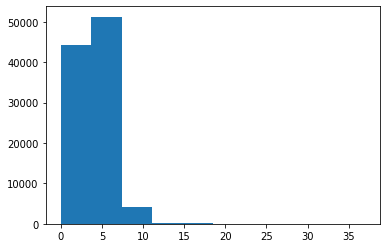

In [ ]:
def get_days(df):
    return df.dt.days

plt.hist(get_days(time_diff))

> From the histogram above, we can see that the majority of the videos were trending between 0 and 10 days of their publish date. The maximum was 37 days.

(99482, 17)
the max difference between trending date and publishing date after removing outliers is:  10 days 00:00:00


(array([ 1092., 11572., 15413., 16246., 16842., 15747., 12058.,  6628.,
         2568.,  1316.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

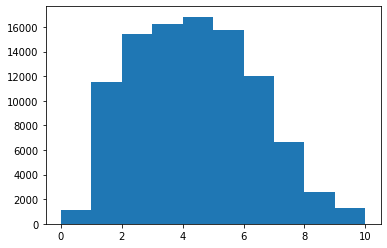

In [ ]:
videosTestDF = remove_outliers(videosDF, ['time_diff'])
print(videosTestDF.shape)
print("the max difference between trending date and publishing date after removing outliers is: ", max(videosTestDF['time_diff']))
plt.hist(get_days(videosTestDF['time_diff']))

In [ ]:
#the mean of the difference between trending and publishing is: 
print(videosDF['time_diff'].mean())
#after removing outliers:
print(videosTestDF['time_diff'].mean())

3 days 23:57:29.950594364
3 days 21:47:08.049295349


> you can see from the distribution of the time deltas that very few videos are trending once they are published, and also as the mean decreased by 2 hours only after removing outliers, we can claim that the number of videos that are trending after 8-10 days of publishing is very small, too.

# Descriptive Analytics

In [ ]:
#let's get an idea about the ranges of the dates in our dataframe 
print("First publishing Date: ", min(videosDF['publishedAt']))
print("Last publishing Date: ", max(videosDF['publishedAt']))
print("First Trending Date: ", min(videosDF['trending_date']))
print("Last Trending Date: ", max(videosDF['trending_date']))
c2020 = videosDF['publishedAt'][videosDF['publishedAt'].dt.year == 2020].count()
c2021 = videosDF['publishedAt'][videosDF['publishedAt'].dt.year == 2021].count()
print("Data in 2020: ", c2020)
print("Data in 2021: ", c2021)

First publishing Date:  2020-08-03 21:51:14
Last publishing Date:  2021-12-20 18:45:40
First Trending Date:  2020-08-12 00:00:00
Last Trending Date:  2021-12-21 00:00:00
Data in 2020:  28732
Data in 2021:  71459


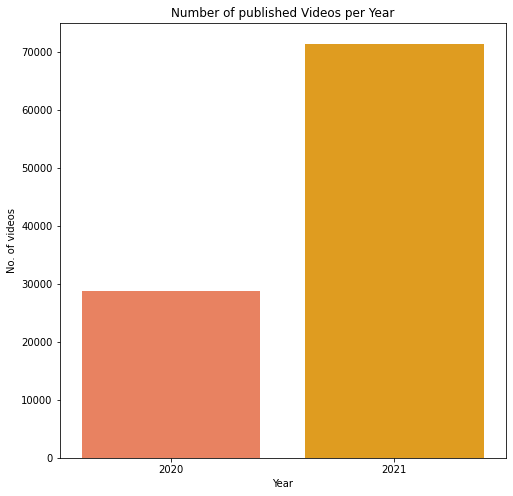

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x=[2020, 2021], y= [c2020, c2021], 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel="Year", ylabel="No. of videos" , title= "Number of published Videos per Year")


In [ ]:
#let's see for example the video that was trending after the maximum number of days from its publishing date
videosDF[['publishedAt', 'trending_date', 'time_diff', 'title']][videosDF['time_diff']==max(time_diff)]

,publishedAt,trending_date,time_diff,title
96185,2021-10-24 21:06:53,2021-11-30,37 days,Highlights: Manchester United 0-5 Liverpool | ...


## Calendar Analysis 

> In this section, we attempt to analyze the effect of weekdays, months and hours on the views.

In [ ]:
def get_weekday_publ(df):
    if df['publishedAt'].weekday() == 5 or df['publishedAt'].weekday() == 6:
        return 1
    else:
        return 0
def get_weekday_trend(df):
    if df['trending_date'].weekday() == 5 or df['trending_date'].weekday() == 6:
        return 1
    else:
        return 0




In [ ]:

# Adding some features for the data analysis 

videosDF['isPublishedWeekend'] = videosDF.apply(get_weekday_publ, axis=1)
videosDF['isTrendingWeekend'] = videosDF.apply(get_weekday_trend, axis=1)
videosDF['published_year'] = pd.DatetimeIndex(videosDF['publishedAt']).year
videosDF['published_month'] = pd.DatetimeIndex(videosDF['publishedAt']).month
videosDF['published_day'] = pd.DatetimeIndex(videosDF['publishedAt']).day
videosDF['trending_year'] = pd.DatetimeIndex(videosDF['trending_date']).year
videosDF['trending_month'] = pd.DatetimeIndex(videosDF['trending_date']).month
videosDF['trending_day'] = pd.DatetimeIndex(videosDF['trending_date']).day
videosDF['published_weekday']= videosDF['publishedAt'].dt.day_name()
videosDF['trending_weekday']= videosDF['trending_date'].dt.day_name()


> does the month name make a difference ? are the videos that are published during a certain month more likely to be trending?

### No. of Videos vs Publishing Month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


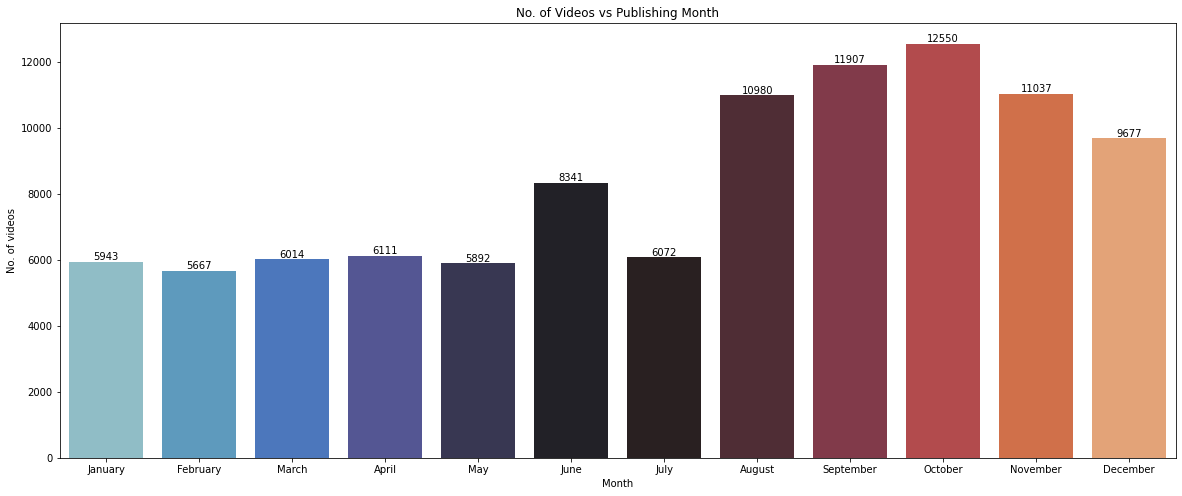

In [ ]:


videosDF['published_month_name'] = videosDF['published_month'].apply(lambda x: calendar.month_name[x])
fig , ax = plt.subplots(figsize=(20,8))
sns.countplot(videosDF['published_month_name'],  palette=('icefire') , order=['January','February','March','April','May','June','July', 'August', 'September' , 'October' , 'November' , 'December'])
plt.title('No. of Videos vs Publishing Month')
plt.xlabel('Month')
plt.ylabel('No. of videos')
ax.bar_label(ax.containers[0])
plt.show()


In [ ]:
#videosDF['published_month_name'].hist()

> this might be deceiving as you might think that videos published between August and Decemeber are actually more likely to be trending, but it is because the data is taken between August 2020 and Decemeber 2021. So, the months between 8 to 12 are repeated twice for the two years. Once you divide by 2, the videos published between 8 and 12 are as likely to be trending as all other months' videos

### No. of Videos vs Trending Weekday

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


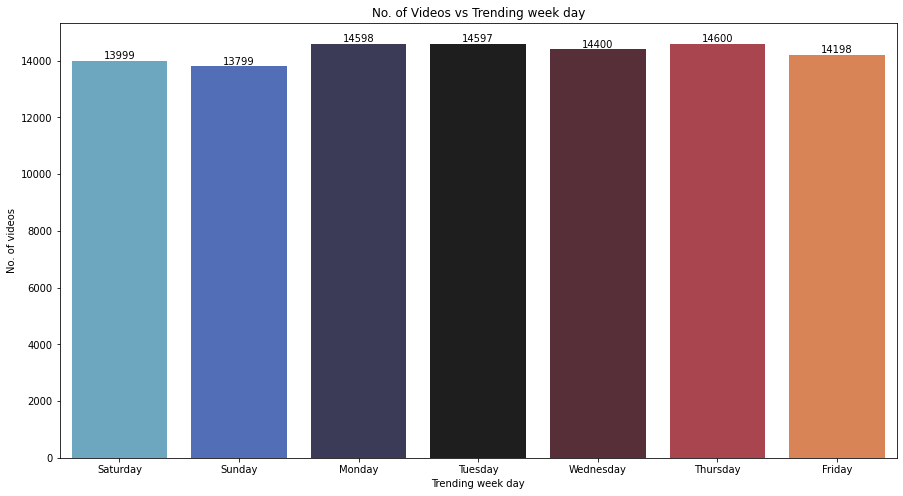

In [ ]:

fig , ax = plt.subplots(figsize=(15,8))
sns.countplot(videosDF['trending_weekday'],  palette=('icefire') , order=['Saturday' , 'Sunday' , 'Monday' , 'Tuesday', 'Wednesday' , 'Thursday' , 'Friday'] )
plt.title('No. of Videos vs Trending week day')
plt.xlabel('Trending week day')
plt.ylabel('No. of videos')
ax.bar_label(ax.containers[0])
plt.show()


###  No. of Videos vs Published Week day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


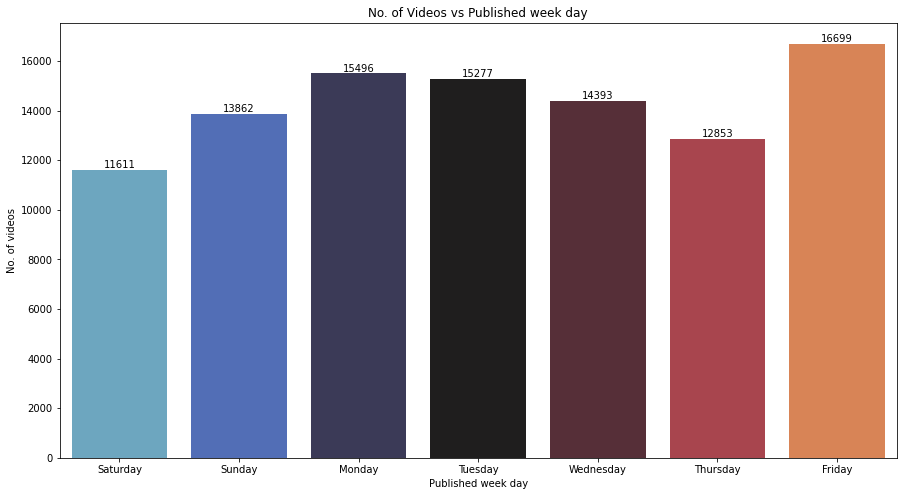

In [ ]:

fig , ax = plt.subplots(figsize=(15,8))
sns.countplot(videosDF['published_weekday'],  palette=('icefire') , order=['Saturday' , 'Sunday' , 'Monday' , 'Tuesday', 'Wednesday' , 'Thursday' , 'Friday'] )
plt.title('No. of Videos vs Published week day')
plt.xlabel('Published week day')
plt.ylabel('No. of videos')
ax.bar_label(ax.containers[0])
plt.show()


## Hours and videos

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


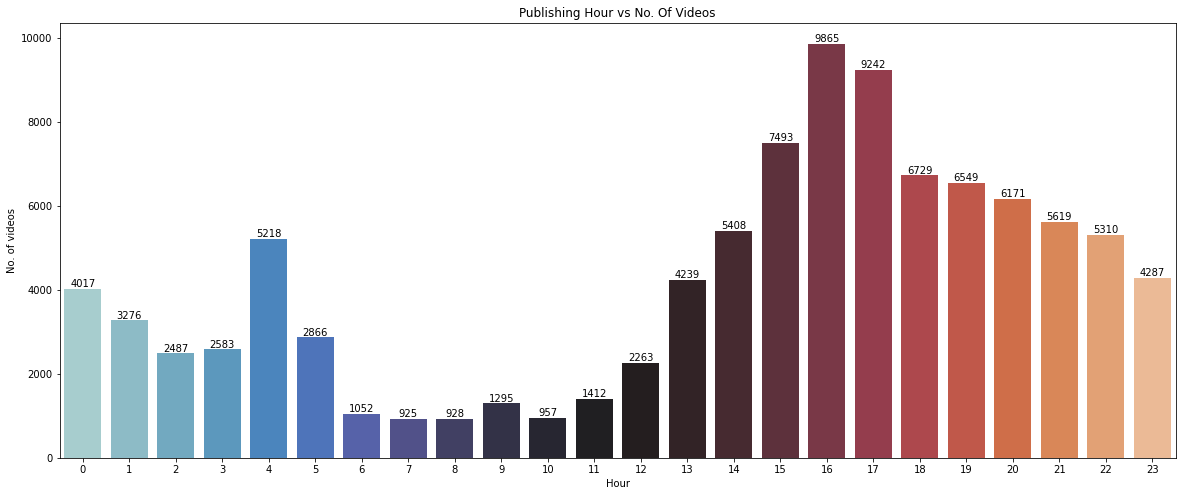

In [ ]:
publishHour = videosDF['publishedAt'].dt.hour
fig , ax = plt.subplots(figsize=(20,8))
sns.countplot(publishHour, palette=('icefire'))
plt.title('Publishing Hour vs No. Of Videos')
plt.xlabel('Hour')
plt.ylabel('No. of videos')
ax.bar_label(ax.containers[0])
plt.show()


In [ ]:
videosDF[['publishedAt', 'isPublishedWeekend', 'trending_date','isTrendingWeekend']].sample(5)

,publishedAt,isPublishedWeekend,trending_date,isTrendingWeekend
63634,2021-06-16 22:39:15,0,2021-06-19,1
97375,2021-12-02 17:00:35,0,2021-12-07,0
22487,2020-12-01 18:00:10,0,2020-12-04,0
28494,2020-12-30 22:00:09,0,2021-01-05,0
60247,2021-06-06 22:06:23,1,2021-06-09,0


> now let's us visualize the view counts for all videos before diving in the categories analysis 

<AxesSubplot:>

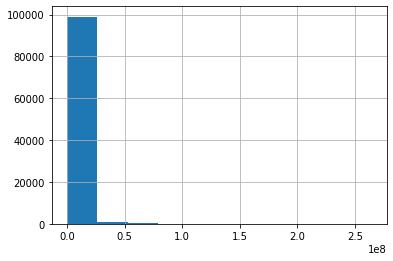

In [ ]:

videosDF['view_count'].hist()

> It's worth noting that the data for all videos in our dataset is actually for trending videos, which already get tons of views; however, you can still see that very few videos perform really well, and the majority can barely get to 100M views

(90653, 28)
the maximum number of views is:  5789567  and minimum is:  0


<AxesSubplot:>

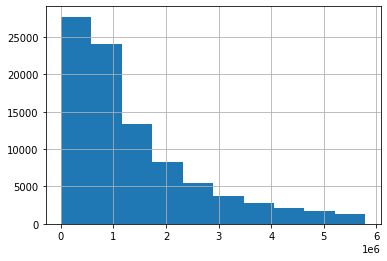

In [ ]:
videosTestDF = remove_outliers(videosDF, ['view_count'])
print(videosTestDF.shape)
print("the maximum number of views is: ", max(videosTestDF['view_count']), " and minimum is: ", min(videosTestDF['view_count']))
videosTestDF['view_count'].hist()

>  we can still see that it is extremely hard to get more views that the number of videos at each points is almost half the number of videos that got 1M fewer views. The problem with the above strategy is that we have counted each video multiple times, so we need to get the maximum number of views per video and then see the true distribution of the views each video get.

In [ ]:
def get_max_value(df, colName):
    return df[['view_count', 'video_id']].groupby(colName).max()

maxViewsPerVid = get_max_value(videosDF, 'video_id')

17944
17944


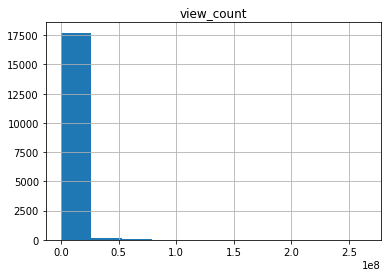

In [ ]:
maxViewsPerVid.hist()
print(len(maxViewsPerVid)) #you can see that the count of unique video IDs match the number of views data points which shows that each video has now been mapped to its max number of views
print(videosDF['video_id'].nunique())

(16279, 1)
the maximum number of views is:  6386579  and minimum is:  0


<AxesSubplot:>

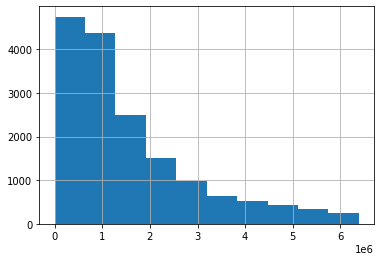

In [ ]:
videosTestDF = remove_outliers(maxViewsPerVid, ['view_count'])
print(videosTestDF.shape)
print("the maximum number of views is: ", max(videosTestDF['view_count']), " and minimum is: ", min(videosTestDF['view_count']))
videosTestDF['view_count'].hist()

> the pattern remains the same, but the number of videos is now much smaller on the y-axis. The question now becomes how can we have videos trending with 0 views?

In [ ]:
def count_rows(df, colName, value):
    return df[[colName]][df[colName] == value].count()

#how many rows have 0 views?
x = count_rows(videosDF, 'view_count', 0) 
print(x) 

view_count    45
dtype: int64


> There are 45 videos that had 0 views at some point, let's see them before dropping them

In [ ]:
zeroV = videosDF[videosDF['view_count']==0]
print(zeroV.shape) #45 videos have 0 views
print(zeroV['video_id'].nunique()) #only 11 vidos create those 45 entries that have 0 videos. This means that these videos have multiple entries with 0 views (thus, I will drop them)



(45, 28)
11


In [ ]:
videosDF[videosDF['video_id']=='BxOEj8ZeX2g']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name
79795,BxOEj8ZeX2g,Tim Bergling's 32nd Birthday,2021-09-07 12:00:08,UCdq61m8s_48EhJ5OM_MCeGw,GoogleDoodles,1,2021-09-09,[None],0,0,0,0,https://i.ytimg.com/vi/BxOEj8ZeX2g/default.jpg,True,True,Today's video Doodle celebrates the 32nd birth...,2 days,0,0,2021,9,7,2021,9,9,Tuesday,Thursday,September
80018,BxOEj8ZeX2g,Tim Bergling's 32nd Birthday,2021-09-07 12:00:08,UCdq61m8s_48EhJ5OM_MCeGw,GoogleDoodles,1,2021-09-10,[None],0,0,0,0,https://i.ytimg.com/vi/BxOEj8ZeX2g/default.jpg,True,True,Today's video Doodle celebrates the 32nd birth...,3 days,0,0,2021,9,7,2021,9,10,Tuesday,Friday,September
80242,BxOEj8ZeX2g,Tim Bergling's 32nd Birthday,2021-09-07 12:00:08,UCdq61m8s_48EhJ5OM_MCeGw,GoogleDoodles,1,2021-09-11,[None],0,0,0,0,https://i.ytimg.com/vi/BxOEj8ZeX2g/default.jpg,True,True,Today's video Doodle celebrates the 32nd birth...,4 days,0,1,2021,9,7,2021,9,11,Tuesday,Saturday,September
80514,BxOEj8ZeX2g,Tim Bergling's 32nd Birthday,2021-09-07 12:00:08,UCdq61m8s_48EhJ5OM_MCeGw,GoogleDoodles,1,2021-09-12,[None],0,0,0,0,https://i.ytimg.com/vi/BxOEj8ZeX2g/default.jpg,True,True,Today's video Doodle celebrates the 32nd birth...,5 days,0,1,2021,9,7,2021,9,12,Tuesday,Sunday,September
80754,BxOEj8ZeX2g,Tim Bergling's 32nd Birthday,2021-09-07 12:00:08,UCdq61m8s_48EhJ5OM_MCeGw,GoogleDoodles,1,2021-09-13,[None],0,0,0,0,https://i.ytimg.com/vi/BxOEj8ZeX2g/default.jpg,True,True,Today's video Doodle celebrates the 32nd birth...,6 days,0,0,2021,9,7,2021,9,13,Tuesday,Monday,September


> Let's drop these videos and while we are at it, let's drop the thumbnail link as we won't need it in our analysis

In [ ]:
print(videosDF.shape)
videosDF = videosDF[videosDF['view_count']!=0]
print(videosDF.shape)

(100191, 28)
(100146, 28)


In [ ]:
videosDF.drop(['thumbnail_link'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Top channels

In [ ]:
top_10_channel = videosDF["channelTitle"].value_counts() 
top_10_channel.head(10)

NFL                    651
NBA                    618
SSSniperWolf           516
MrBeast Gaming         398
SSundee                388
MrBeast                351
ESPN                   328
Saturday Night Live    325
Dude Perfect           302
NBC Sports             284
Name: channelTitle, dtype: int64

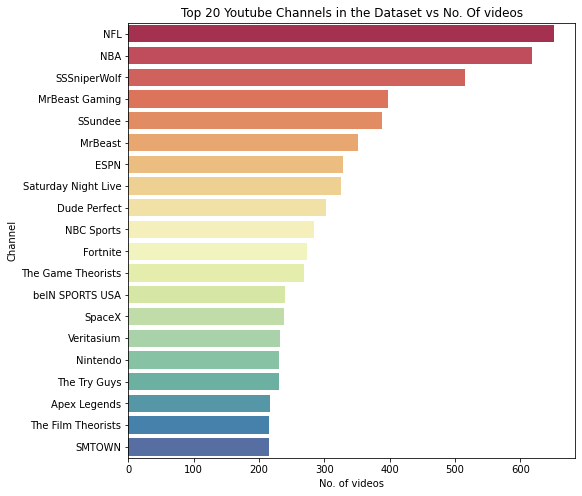

In [ ]:
cdf = videosDF.groupby("channelTitle").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
ch_ = sns.barplot(x="video_count", y="channelTitle", data=cdf,palette=('Spectral'), ax=ax)
ch_ = ax.set(xlabel="No. of videos", ylabel="Channel" , title="Top 20 Youtube Channels in the Dataset vs No. Of videos")

### Investigating the Distribution of the Views for the top 20 Channels

<Figure size 432x288 with 0 Axes>

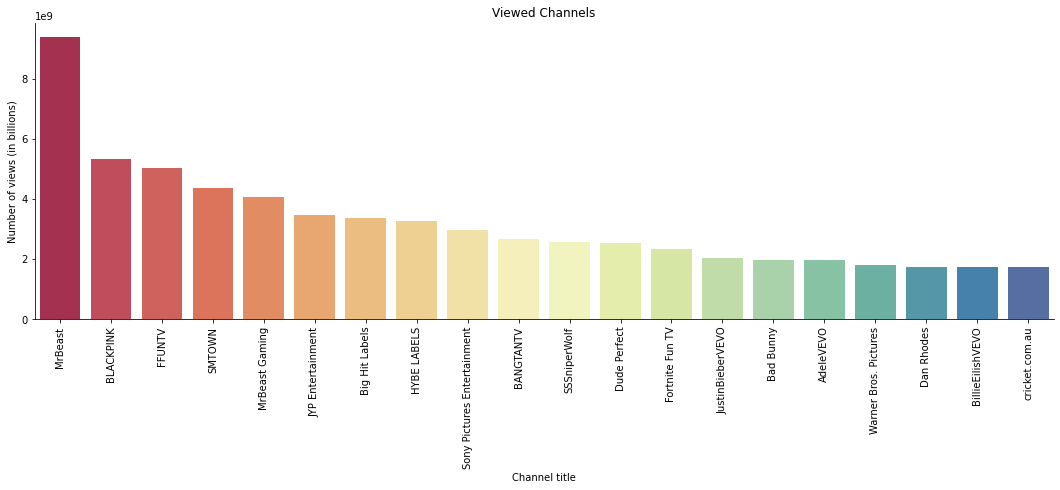

In [ ]:
channelViews = videosDF.groupby('channelTitle')[['view_count']].sum().reset_index()
channelViews.sort_values(by='view_count',inplace=True,ascending=False)
plt.clf()
channel_views = channelViews.head(20)
sns.catplot(x='channelTitle',y='view_count',data=channel_views,kind='bar', palette=('Spectral'),aspect=3)
plt.xticks(rotation=90)
plt.xlabel('Channel title')
plt.ylabel('Number of views (in billions)')
plt.title('Viewed Channels')
plt.show()

### Investigating the effect of the title length on the number of views

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


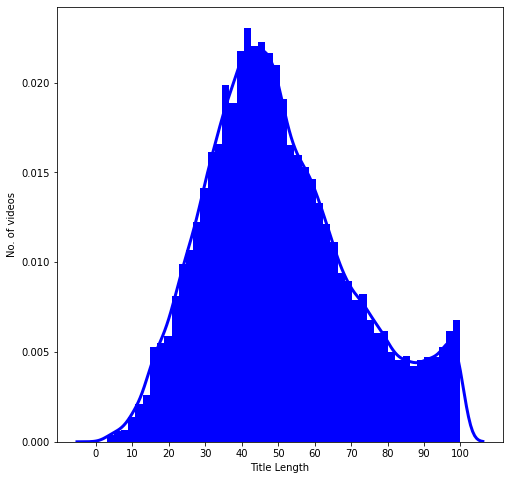

In [ ]:
videosDF["title_length"] = videosDF["title"].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(8,8))
title_len = sns.distplot(videosDF["title_length"], kde=True, rug=False, hist_kws={'alpha': 1 , "color": "b", "linewidth": 3}, kde_kws={"color": "b" , "linewidth": 3} ,color='cyan',ax=ax)
title_len = ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

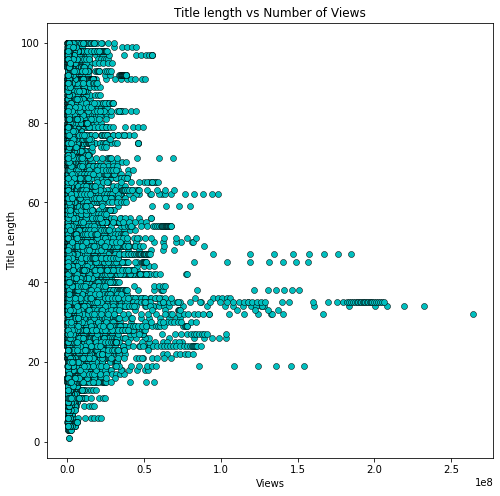

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
number_views= ax.scatter(x=videosDF['view_count'], y=videosDF['title_length'],color='c', edgecolors="#000000", linewidths=0.5)
number_views = ax.set(xlabel="Views", ylabel="Title Length" , title='Title length vs Number of Views')

### Investigating the percentage of Comments Disabled in videos

Text(0.5, 1.0, 'Comments Enabled?')

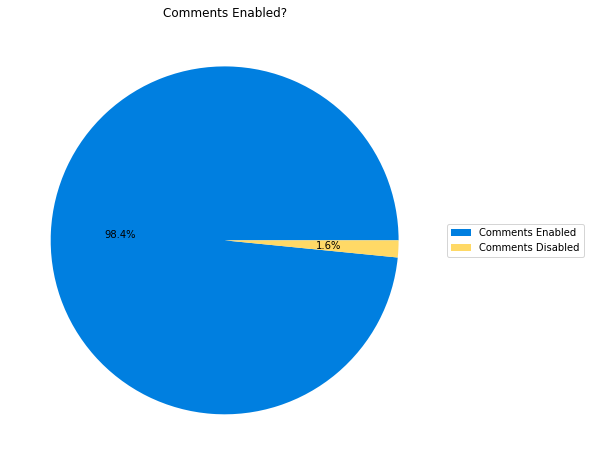

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
commentsDisabled_value_counts = videosDF["comments_disabled"].value_counts().to_dict()
labels=['Comments Enabled', 'Comments Disabled']
plt.pie(x=[commentsDisabled_value_counts[False], commentsDisabled_value_counts[True]], colors = ['#007fe0','#ffd966','#57b6ff','#ed893e'],autopct='%1.1f%%')
plt.legend(labels, loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.title("Comments Enabled?")

### Investigating the percentage of Ratings Disabled in videos

Text(0.5, 1.0, 'Ratings Enabled?')

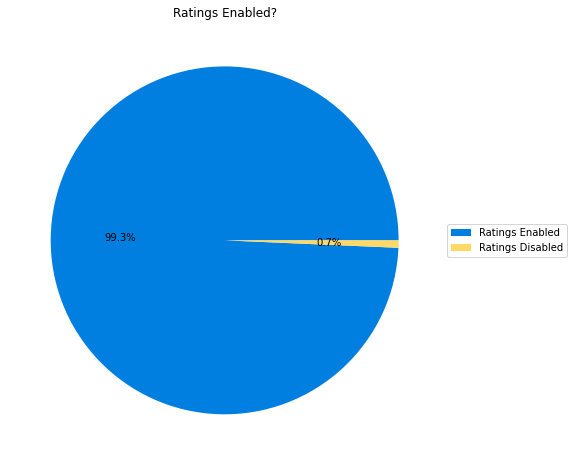

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
RatingsDisabled_value_counts = videosDF["ratings_disabled"].value_counts().to_dict()
labels=['Ratings Enabled', 'Ratings Disabled']
plt.pie(x=[RatingsDisabled_value_counts[False], RatingsDisabled_value_counts[True]], colors = ['#007fe0','#ffd966','#57b6ff','#ed893e'],autopct='%1.1f%%')
plt.legend(labels, loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.title("Ratings Enabled?")

##Tags per video count

<AxesSubplot:>

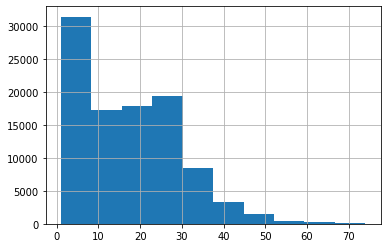

In [ ]:
videosDF["tags_count"] = videosDF["tags"].apply(lambda x: x.count('|') + 1)
videosDF["tags_count"].hist()

##is the video sponsored?

In [ ]:
from re import search

videosDF[videosDF["description"].isna()]["video_id"].count()

key = "sponsor"
def sponsered(v):
    # print(v)
    if pd.isnull(v):
        return 0
    if search(key,v):
        return 1
    else: 
        return 0
videosDF["sponsered"] = videosDF["description"].map(sponsered)
videosDF["sponsered"].value_counts()

0    94977
1     5169
Name: sponsered, dtype: int64

## Analyzing Likes, Dislikes, Comments, Views


Text(0.5, 1.0, 'Linear Corrleations between KPIs')

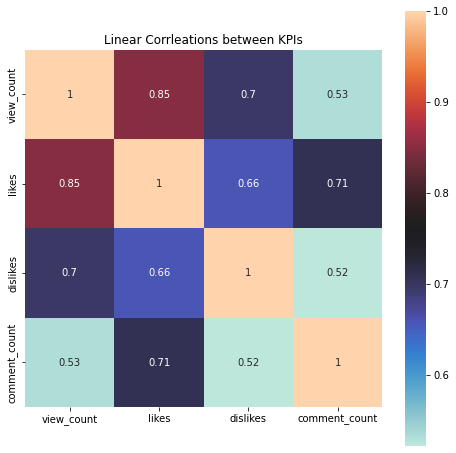

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
KPI_cols = ['view_count','likes','dislikes','comment_count']
sns.heatmap(videosDF[KPI_cols].corr(),square=True,annot=True,cmap='icefire');
plt.title("Linear Corrleations between KPIs")

> As we can notice, there are some positive linear correlations between some of the KPIs, such as the likes and views counts for trendy videos. hence, let's investigate these relationships further.

##Likes Vs Dislikes Ratio

In [ ]:
# number of videos with 0 likes
videosDF[videosDF["likes"] == 0]["video_id"].count()
# number of videos with 0 likes and 0 dislikes
videosDF[ (videosDF["likes"] == 0) & (videosDF["dislikes"] == 0) ]["video_id"].count()

# number of videos with 0 dislikes
videosDF[videosDF["dislikes"] == 0]["video_id"].count()

videosDF["likes/dislikes"] = videosDF["likes"] / (videosDF["likes"] + videosDF["dislikes"])
videosDF["likes/dislikes"].sort_values()

93370    0.099
93124    0.114
13527    0.123
13291    0.126
13082    0.133
         ...  
98786      NaN
98787      NaN
98788      NaN
98789      NaN
98790      NaN
Name: likes/dislikes, Length: 100146, dtype: float64

In [ ]:
print("Number of videos with likes < dislikes: ", videosDF[videosDF["likes/dislikes"]<0.5]["video_id"].count())
print("Number of videos with likes > dislikes: ", videosDF[videosDF["likes/dislikes"]>0.5]["video_id"].count())
print("Number of videos with 0 likes and 0 dislikes: ", videosDF[videosDF["likes/dislikes"].isna()]["video_id"].count())

Number of videos with likes < dislikes:  401
Number of videos with likes > dislikes:  99062
Number of videos with 0 likes and 0 dislikes:  683


<AxesSubplot:>

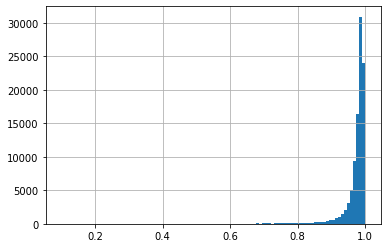

In [ ]:
videosDF[~videosDF["likes/dislikes"].isna()]["likes/dislikes"].hist(bins=100)

In [ ]:
videosDF[videosDF["likes/dislikes"].isna()]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes
1224,rZUTFDjDZSQ,The Paris Hilton you never knew | This Is Pari...,2020-08-17 16:00:13,UCwl5c3q0uBK3mVv9OXQUeeQ,Paris Hilton,24,2020-08-18,Paris Hilton|Paris|Hilton|Documentary|This Is ...,330188,0,0,1362,False,True,"This September 14th, meet the real Paris Hilto...",1 days,0,0,2020,8,17,2020,8,18,Monday,Tuesday,August,66,7,0,NaN
1286,b8pSdMHicYw,What Really Happened to Sean O'Malley vs Marlo...,2020-08-16 05:30:01,UCQ2xsPeC159i2RzHAme1gmg,kenanK TV,17,2020-08-18,sean o malley|sean o'malley|ufc 252|ufc 252 se...,391246,0,0,969,False,True,In Sean O'malley's fight against Marlon Chito ...,2 days,1,0,2020,8,16,2020,8,18,Sunday,Tuesday,August,87,18,0,NaN
1439,RHPRUe-aZHA,SuperM 슈퍼엠 '100' MV Reaction,2020-08-18 15:00:17,UCcjV926qiLr_Ghw6A0lTNjA,SuperM,10,2020-08-19,[None],958787,0,0,8314,False,True,SuperM's new single “100” is out!🎧Listen and d...,1 days,0,0,2020,8,18,2020,8,19,Tuesday,Wednesday,August,28,1,0,NaN
1455,rZUTFDjDZSQ,The Paris Hilton you never knew | This Is Pari...,2020-08-17 16:00:13,UCwl5c3q0uBK3mVv9OXQUeeQ,Paris Hilton,24,2020-08-19,Paris Hilton|Paris|Hilton|Documentary|This Is ...,600752,0,0,1898,False,True,"This September 14th, meet the real Paris Hilto...",2 days,0,0,2020,8,17,2020,8,19,Monday,Wednesday,August,66,7,0,NaN
1529,b8pSdMHicYw,What Really Happened to Sean O'Malley vs Marlo...,2020-08-16 05:30:01,UCQ2xsPeC159i2RzHAme1gmg,kenanK TV,17,2020-08-19,sean o malley|sean o'malley|ufc 252|ufc 252 se...,396636,0,0,947,False,True,In Sean O'malley's fight against Marlon Chito ...,3 days,1,0,2020,8,16,2020,8,19,Sunday,Wednesday,August,87,18,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98786,qcNhqYBr2To,Why Japan is Shrinking Fast,2021-12-09 15:30:06,UCP5tjEmvPItGyLhmjdwP7Ww,RealLifeLore,27,2021-12-14,real life lore|real life lore maps|real life l...,934213,0,0,5122,False,True,Click https://bit.ly/3oL97pK and use code REAL...,5 days,0,0,2021,12,9,2021,12,14,Thursday,Tuesday,December,27,18,0,NaN
98787,3vERcLZHg2o,LIFE FLIGHT TAKES OUR BABY | PARENTS WORST NI...,2021-12-10 14:00:01,UCwh2SF7McSUf1GVFVk0nP8w,Trent & Allie,22,2021-12-14,van life|vanlife|trent and allie|eamon and bec...,428390,0,0,9159,False,True,Save 40% or more on a Simplisafe security syst...,4 days,0,0,2021,12,10,2021,12,14,Friday,Tuesday,December,53,37,0,NaN
98788,S2zQTYQhm28,THIS will BLOW. YOUR. MIND!🤯,2021-12-09 04:55:05,UC8TOSHpiM1hjNTNyHReLe5g,TheMagicMatt,24,2021-12-14,[None],2265871,0,0,6821,False,True,NaN,5 days,0,0,2021,12,9,2021,12,14,Thursday,Tuesday,December,28,1,0,NaN
98789,qz2vodkoj7I,Grupo Firme & Maluma - Cada Quien (Official Vi...,2021-12-07 18:00:10,UCFlC8U0Uif2hF0FIgsSIIYQ,Grupo Firme,10,2021-12-14,Grupo Firme|Grupo Firme music|Grupo Firme mix ...,12324613,0,0,13263,False,True,Grupo Firme & Maluma performing - Cada Quien -...,7 days,0,0,2021,12,7,2021,12,14,Tuesday,Tuesday,December,50,21,0,NaN


## Viewcount vs Likes

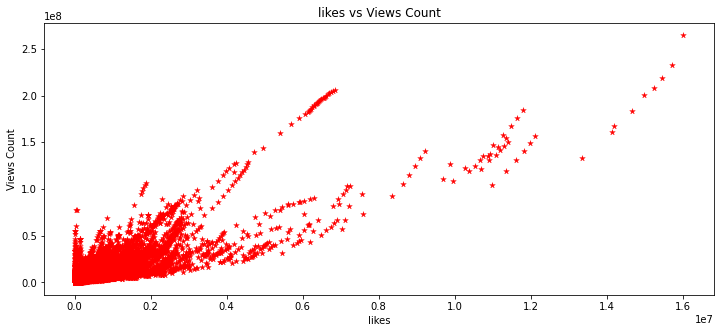

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(videosDF['likes'],videosDF['view_count'],marker='*',
            linewidths=0.3, color='r')
plt.title("likes vs Views Count")
plt.xlabel("likes")
plt.ylabel("Views Count")
plt.show()

In [ ]:
# Create converted rates columns
videosDF['comment_rate'] = videosDF['comment_count'] / videosDF['view_count']
videosDF['dislike_rate'] =  videosDF ['dislikes'] / videosDF['view_count']

## Emperical Distribution for Comment rate and dislike Rate

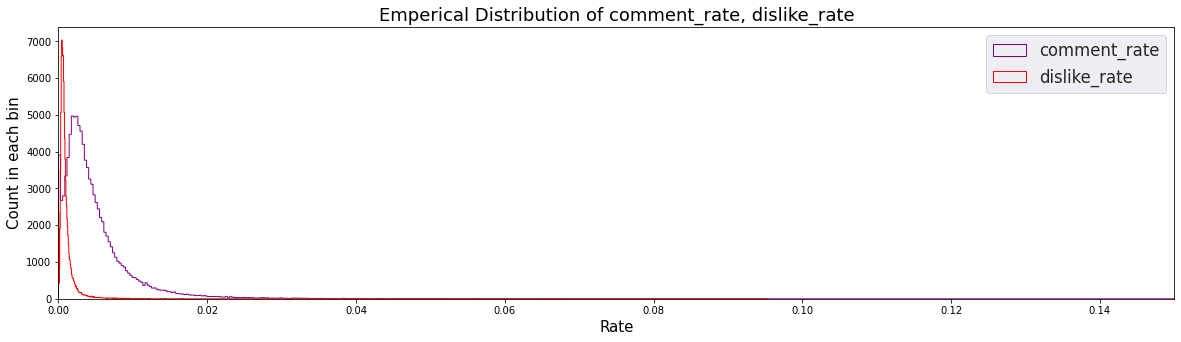

In [ ]:
plt.figure(figsize=(20,5))
plt.hist(videosDF[np.isfinite(videosDF['comment_rate'])]['comment_rate'],label='comment_rate',bins=1500,
         color='purple', histtype='step')
plt.hist(videosDF[np.isfinite(videosDF['dislike_rate'])]['dislike_rate'],label='dislike_rate',bins=1500,
         color ='Red', histtype='step')

plt.title("Emperical Distribution of comment_rate, dislike_rate", 
         fontsize=18)
sns.set(font_scale=1.5)
plt.xlabel("Rate", fontsize=15)
plt.ylabel("Count in each bin", fontsize=15)
plt.xlim(0,0.15)
plt.legend()
plt.show()

> we observe that the majority of trending videos have both low dislike rates and low comment rates. And we can see that the shape of these two distributions are similar (both right skewed).

## Dislikes vs Comment rate

Do people tend to comment a lot on a video or not when they do not like it?

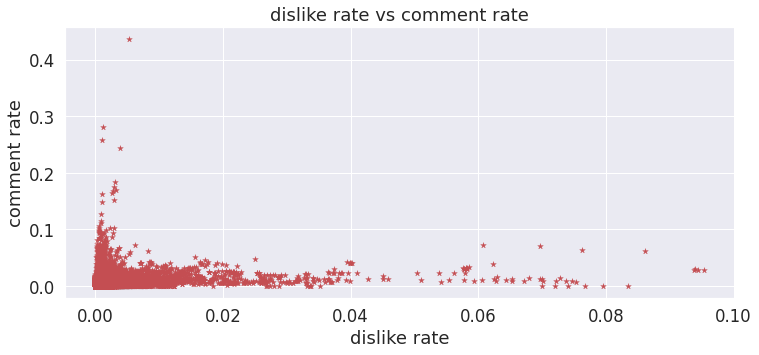

In [ ]:
plt.figure(figsize=(12,5))
plt.scatter(videosDF['dislike_rate'],videosDF['comment_rate'],marker='*',
            linewidths=0.3, color='r')
plt.title("dislike rate vs comment rate")
plt.xlabel("dislike rate")
plt.ylabel("comment rate")
plt.show()

## No. of Videos Vs Views

I will explore a Subset of videos that have views below 5 million.




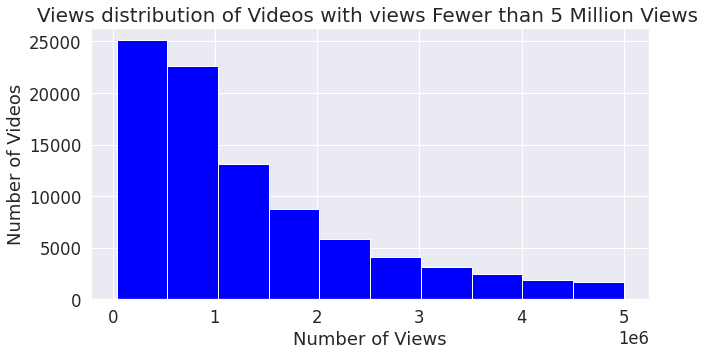

In [ ]:
views_5M = videosDF[videosDF['view_count'] < 5e6]['view_count']
plt.figure(figsize=(10,5))
v2 = views_5M.hist(color='blue')
plt.xlabel('Number of Views', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Views distribution of Videos with views Fewer than 5 Million Views ', fontsize=20);

## No. of Videos Vs Likes

I will explore a Subset of videos that have likes below 20,000.




Text(0.5, 1.0, 'Likes distribution of Videos with likes Fewer than 20k Likes')

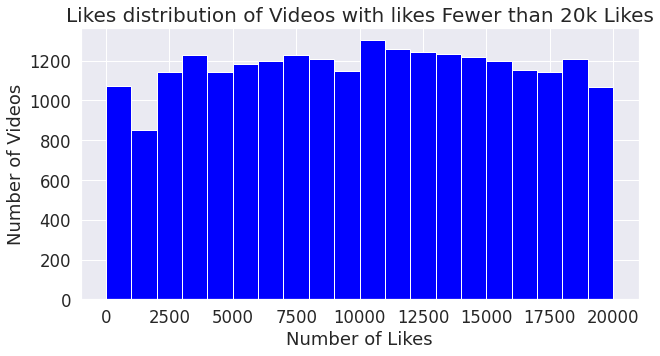

In [ ]:
likes_20k = videosDF[videosDF['likes'] < 2e4]['likes']
plt.figure(figsize=(10,5))
# Histogram of the likes data for videos with likes below 20 thousand
l2 = likes_20k.hist(bins=20,color='blue')
plt.xlabel('Number of Likes', fontsize=18)
plt.ylabel('Number of Videos', fontsize=18)
plt.title('Likes distribution of Videos with likes Fewer than 20k Likes', fontsize=20)

## Title Word Choice Analysis 

In [ ]:
title_words = list(videosDF["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(25)

[('-', 26453),
 ('|', 25472),
 ('The', 12247),
 ('the', 8636),
 ('(Official', 7595),
 ('I', 7368),
 ('Video)', 6890),
 ('&', 6769),
 ('in', 6495),
 ('to', 6299),
 ('a', 5441),
 ('of', 5140),
 ('A', 4293),
 ('and', 4088),
 ('Music', 4043),
 ('Trailer', 3580),
 ('on', 3284),
 ('2021', 3120),
 ('To', 2998),
 ('My', 2938),
 ('Official', 2802),
 ('with', 2672),
 ('Minecraft', 2536),
 ('You', 2402),
 ('at', 2292)]

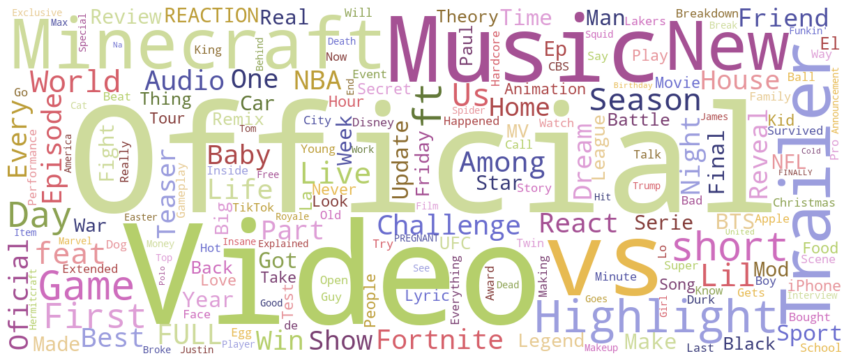

In [ ]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

##Category vs number of trending videos

In [ ]:
with open("/content/drive/Shareddrives/DS Project/US_category_id.json") as f:
    categories = json.load(f)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
videosDF['category_name'] = videosDF['categoryId'].map(cat_dict)

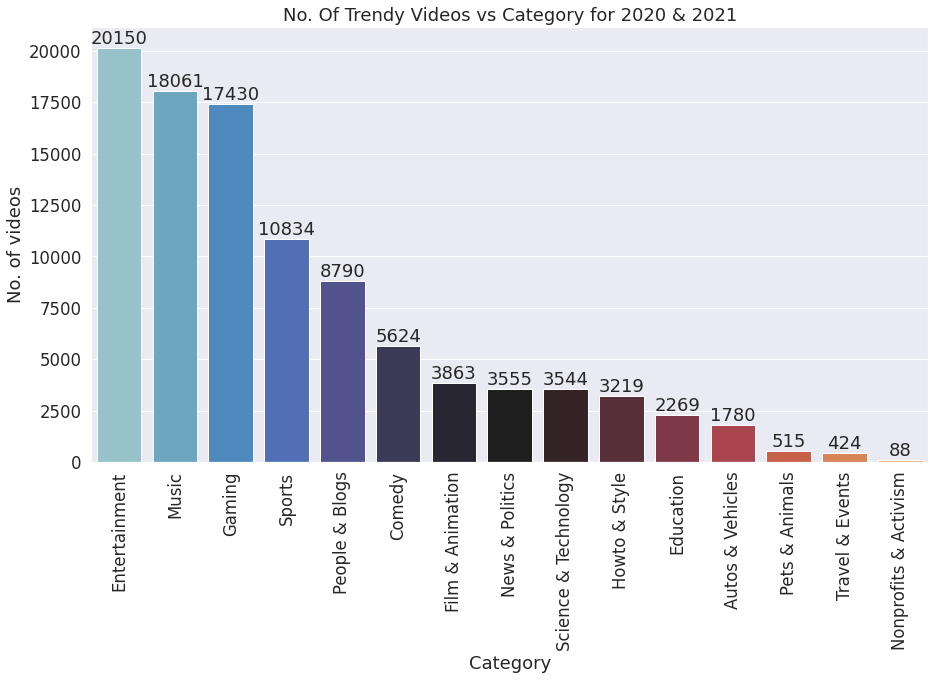

In [ ]:
cdf = videosDF["category_name"].value_counts().to_frame().reset_index()
cdf.rename(columns={"index": "category_name", "category_name": "No_of_videos"}, inplace=True)
fig, ax = plt.subplots(figsize=(15,8))
_ = sns.barplot(x="category_name", y="No_of_videos", data=cdf, 
                palette='icefire', ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.bar_label(ax.containers[0])
_ = ax.set(xlabel="Category", ylabel="No. of videos" , title="No. Of Trendy Videos vs Category for 2020 & 2021")

## Conclusions From Descriptive Analytics




1.   The delimiters - and | were common in trending video titles.
2.   The words 'Official', 'Video', 'Trailer', 'Minecraft', and '2021' were common also in trending video titles
3. The Majority of the trendy videos have titles between 30 and 50 characters 
4. The category that has the largest number of trending videos is 'Entertainment' with 20,161 videos, followed by 'Music' category with 18,069 videos, followed by 'Gaming' category with 1730 videos.
5. All the videos have equal chance of being trendy at any day. however, Friday as a publish day has a slightly better chance. 
6. Published videos at 4 & 5 pm has the highsht probability of being a trend. 
7. Most of the Trendy values were published between August - December. 
8. The more the people like a video, the more likely that they will comment and vice versa. This means that people do not tend to comment negatively and communicate their dislikeness to a video publicly. 
9. There is a High Correlation between views_count and likes for trendy videos (around 85%)
10. The Majority of the trendy videos cameout in 2021 and this can be related to the pandemic. 
11. The Top 5 video producing youtube channels in the US are: NFL, NBA, SSSniperWolf, MrBeast Gaming and SSundee. However, the top 5 viewed channels are: Mr. Beast, BlackPink, FFUNTV, SMTOWN, and Mr. Beast Gaming

#Missing Values Handling and some Date cleaning

In [ ]:
#Missing values and Imputation

def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        if missing_vals != 0:
          sum=df[col].isnull().sum()
          print(f"Column '{col}' has {sum} Null values , percentage = {(sum/df.shape[0])*100:0.2f} %")
            
missing_cols(videosDF)

Column 'description' has 1831 Null values , percentage = 1.83 %
Column 'likes/dislikes' has 683 Null values , percentage = 0.68 %


In [ ]:
#unique videos with no description

nulldesc= videosDF.loc[videosDF['description'].isnull()]
nulldesc['video_id'].nunique()

390

In [ ]:
#Null descriptions means no description found, so I will replace it with an empty string

#first, convert description from object to string
videosDF['description'] = videosDF['description'].astype('str') 

In [ ]:
#replace nan with empty string
videosDF['description'] = videosDF['description'].replace('nan', '')

In [ ]:
#make sure all nans are replaced
nulldesc=videosDF.loc[videosDF['description']=='']
nulldesc['video_id'].nunique()

390

In [ ]:
print("Number of unique video titles: ",len(videosDF['title'].unique()))
print("Number of unique video IDs: ",len(videosDF['video_id'].unique()))

Number of unique video titles:  18323
Number of unique video IDs:  17934


In [ ]:
Utitles= videosDF.groupby(['video_id','publishedAt','channelId'])['title'].apply(lambda x: x.unique()).reset_index()

In [ ]:
Utitles

,video_id,publishedAt,channelId,title
0,--14w5SOEUs,2021-06-10 16:00:00,UCGIelM2Dj3zza3xyV3pL3WQ,"[Migos - Avalanche, Migos - Avalanche (Officia..."
1,--40TEbZ9Is,2021-09-20 01:03:32,UClBKH8yZRcM4AsRjDVEdjMg,[Supporting Actress in a Comedy: 73rd Emmys]
2,--DKkzWVh-E,2021-12-07 13:00:00,UCMOqf8ab-42UUQIdVoKwjlQ,[Why Retaining Walls Collapse]
3,--FmExEAsM8,2021-12-01 09:00:03,UCYDmx2Sfpnaxg488yBpZIGg,[IVE 아이브 'ELEVEN' MV]
4,--SvHNpSvpk,2020-09-11 15:00:00,UClW4jraMKz6Qj69lJf-tODA,[YoungBoy Never Broke Again - Dead Trollz [Off...
...,...,...,...,...
17933,zyY6G1UX7HU,2021-02-11 21:36:15,UC95x-m2toVa_BRmmQ6SrIYg,[The Gaines' Living Room Renovation is Complet...
17934,zyrJ0j7x9-4,2020-08-25 03:45:13,UCoGIPQ7M4NWai7LRgRhaSOg,[FlightReacts Plays NBA 2K21 For The FIRST Tim...
17935,zzd4ydafGR0,2021-02-12 05:03:49,UCEB4a5o_6KfjxHwNMnmj54Q,[Lil Tjay - Calling My Phone (feat. 6LACK) [Of...
17936,zziBybeSAtw,2021-01-16 05:39:05,UCWJ2lWNubArHWmf3FIHbfcQ,[PELICANS at LAKERS | FULL GAME HIGHLIGHTS | J...


In [ ]:
titles=list(Utitles['title'])

In [ ]:
multTitles=[x for x in titles if len(x)>1]

In [ ]:
len(multTitles)

405

In [ ]:
videosDF.loc[videosDF['title']=='Unboxing my $1,000,000 Car']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes,comment_rate,dislike_rate,category_name
4012,rviFWKEy6kE,"Unboxing my $1,000,000 Car",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-01,TheStradman|Stradman|Stradman Car Collection|S...,1063942,128815,2365,20944,False,False,Thank you to everyone who has supported me the...,1 days,0,0,2020,8,31,2020,9,1,Monday,Tuesday,August,26,19,0,0.982,0.02,0.002,Autos & Vehicles


In [ ]:
videosDF.loc[videosDF['title']=='Unboxing my $1,000,000 Bugatti!']

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes,comment_rate,dislike_rate,category_name
4242,rviFWKEy6kE,"Unboxing my $1,000,000 Bugatti!",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-02,TheStradman|Stradman|Stradman Car Collection|S...,1318011,138316,2981,21857,False,False,Thank you to everyone who has supported me the...,2 days,0,0,2020,8,31,2020,9,2,Monday,Wednesday,August,31,19,0,0.979,0.017,0.002,Autos & Vehicles
4487,rviFWKEy6kE,"Unboxing my $1,000,000 Bugatti!",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-03,TheStradman|Stradman|Stradman Car Collection|S...,1443231,143302,3142,22033,False,False,Thank you to everyone who has supported me the...,3 days,0,0,2020,8,31,2020,9,3,Monday,Thursday,August,31,19,0,0.979,0.015,0.002,Autos & Vehicles
4717,rviFWKEy6kE,"Unboxing my $1,000,000 Bugatti!",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-04,TheStradman|Stradman|Stradman Car Collection|S...,1494518,144909,3198,22082,False,False,Thank you to everyone who has supported me the...,4 days,0,0,2020,8,31,2020,9,4,Monday,Friday,August,31,19,0,0.978,0.015,0.002,Autos & Vehicles
4930,rviFWKEy6kE,"Unboxing my $1,000,000 Bugatti!",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-05,TheStradman|Stradman|Stradman Car Collection|S...,1519733,145749,3220,22133,False,False,Thank you to everyone who has supported me the...,5 days,0,1,2020,8,31,2020,9,5,Monday,Saturday,August,31,19,0,0.978,0.015,0.002,Autos & Vehicles
5173,rviFWKEy6kE,"Unboxing my $1,000,000 Bugatti!",2020-08-31 18:00:06,UC21Kozr_K0yDM-VjoihG9Aw,TheStradman,2,2020-09-06,TheStradman|Stradman|Stradman Car Collection|S...,1533735,146174,3235,22162,False,False,Thank you to everyone who has supported me the...,6 days,0,1,2020,8,31,2020,9,6,Monday,Sunday,August,31,19,0,0.978,0.014,0.002,Autos & Vehicles


> Probably, Videos are renamed after a day or two and that's why we have the same id for slightly different titles in the next couple of days in the trend. So, it is not a mistake and we will not remove or do changes in these columns. We will use the video id as the identifier for the video, and we can also study the effect of choice of title words or the effect of renaming on the trendiness of the video

In [ ]:
#Different videos can have the same title, so we can expect different ids for the same title.

#However, we will check videos with same title, channel & published time together to ensure that no same video has different id
Utitles=videosDF.groupby(['title','publishedAt','channelId'])['video_id'].apply(lambda x: x.unique()).reset_index()
ids=list(Utitles['video_id'])
[x for x in ids if len(x)>1]

[]

In [ ]:
#Duplicates

videosDF.duplicated().sum()


83

In [ ]:
#drop duplicates
videosDF = videosDF.drop_duplicates(keep="first")

In [ ]:
#Duplicates in id and trending date (same video reported more than once in the same day) --> select the latest

UIDs_list=list(videosDF['video_id'].unique())


In [ ]:
'''
df1 = videosDF.groupby(['video_id','trending_date']).filter(lambda x: len(x) > 1)
df2 = df1.groupby(['video_id','trending_date']).max()
df3 = df2.reset_index() #from groupby to df "contains only duplicated entries"

id_date = list(zip(df3['video_id'],df3['trending_date']))

for i in id_date:
  index_names = videosDF[ (videosDF['video_id'] == i[0]) & (videosDF['trending_date'] ==i[1])].index
  videosDF.drop(index_names, inplace = True)

videosDF = pd.concat([videosDF, df3])
'''



'\ndf1 = videosDF.groupby([\'video_id\',\'trending_date\']).filter(lambda x: len(x) > 1)\ndf2 = df1.groupby([\'video_id\',\'trending_date\']).max()\ndf3 = df2.reset_index() #from groupby to df "contains only duplicated entries"\n\nid_date = list(zip(df3[\'video_id\'],df3[\'trending_date\']))\n\nfor i in id_date:\n  index_names = videosDF[ (videosDF[\'video_id\'] == i[0]) & (videosDF[\'trending_date\'] ==i[1])].index\n  videosDF.drop(index_names, inplace = True)\n\nvideosDF = pd.concat([videosDF, df3])\n'

## Dropping columns where comments where disabled




In [ ]:
x = videosDF[videosDF['comments_disabled']==True] 
x.shape

(1573, 34)

In [ ]:
x.sample()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes,comment_rate,dislike_rate,category_name
41253,hCodxDpHxhE,Piers Clashes With Trisha Goddard Over Meghan ...,2021-03-08 11:21:31,UCq18eeL7D9Vd8DhjMcLh9QQ,Good Morning Britain,24,2021-03-10,good morning britain|breakfast show|news|morni...,1874804,16108,6079,0,True,False,Following the Duke and Duchess of Sussex’s lan...,2 days,0,0,2021,3,8,2021,3,10,Monday,Wednesday,March,94,10,0,0.726,0.0,0.003,Entertainment


In [ ]:
xx = videosDF[videosDF['ratings_disabled']==True] 
xx.shape

(682, 34)

In [ ]:
xx.sample()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes,comment_rate,dislike_rate,category_name
98760,ehOrsedsq3Q,Soulmate control’s your…✋😳 (PART 1) #soulmate ...,2021-12-09 05:15:09,UC_oMKGSjJp838-WKqp0phiQ,Brianna Mizura,1,2021-12-14,[None],3982374,0,0,909,False,True,,5 days,0,0,2021,12,9,2021,12,14,Thursday,Tuesday,December,61,1,0,NaN,2.283e-04,0.0,Film & Animation


In [ ]:
yy =  videosDF[(videosDF['ratings_disabled']== True) & (videosDF['comments_disabled']==True)]
yy.shape 
yy['video_id'].nunique()

33

# Feature Engineering 

## Sentiment Analysis 

In [ ]:
import json

# read file
cat_path='/content/drive/Shareddrives/DS Project/US_category_id.json'
with open(cat_path, 'r') as f:  # reading one randomly selected json files to make sense of its contents
    data = f.read()
# parse file
obj = json.loads(data)


In [ ]:
obj

{'etag': 'HIrK3n45Uw2IYz9_U2-gK1OsXvo',
 'items': [{'etag': 'IfWa37JGcqZs-jZeAyFGkbeh6bc',
   'id': '1',
   'kind': 'youtube#videoCategory',
   'snippet': {'assignable': True,
    'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Film & Animation'}},
  {'etag': '5XGylIs7zkjHh5940dsT5862m1Y',
   'id': '2',
   'kind': 'youtube#videoCategory',
   'snippet': {'assignable': True,
    'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Autos & Vehicles'}},
  {'etag': 'HCjFMARbBeWjpm6PDfReCOMOZGA',
   'id': '10',
   'kind': 'youtube#videoCategory',
   'snippet': {'assignable': True,
    'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Music'}},
  {'etag': 'ra8H7xyAfmE2FewsDabE3TUSq10',
   'id': '15',
   'kind': 'youtube#videoCategory',
   'snippet': {'assignable': True,
    'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Pets & Animals'}},
  {'etag': '7mqChSJogdF3hSIL-88BfDE-W8M',
   'id': '17',
   'kind': 'youtube#videoCategory',
   'snippet': {'assignable': True,
    'c

In [ ]:
#Videos.drop('category', axis=1, inplace=True)


In [ ]:
category_id = {}
Videos['categoryId'] = Videos['categoryId'].astype(str) 
with open(cat_path, 'r') as f:
    d = json.load(f)
    for category in d['items']:
        category_id[category['id']] = category['snippet']['title']
Videos.insert(2, 'category', Videos['categoryId'].map(category_id))


In [ ]:
stopwords_list = stopwords.words('english')
len(stopwords_list)

179

In [ ]:
stopwords_cap=[word.capitalize() for word in stopwords_list]

In [ ]:
stopwords_list+=stopwords_cap

In [ ]:
categories = Videos['category'].unique() # unique video categories
categories # printing 

array(['Entertainment', 'Education', 'Music', 'Sports', 'People & Blogs',
       'Autos & Vehicles', 'Comedy', 'Science & Technology',
       'Howto & Style', 'Film & Animation', 'Gaming', 'News & Politics',
       'Travel & Events', 'Pets & Animals', 'Nonprofits & Activism'],
      dtype=object)

In [ ]:
def extract_tags(category):
    temp = Videos[Videos['category'] == category]
    #tags = []
    tags=temp['tags'].tolist()
    #for t in temp['tags']:
    #    tags.append(t)
        
    return tags

In [ ]:
def clean_tags(tags):
    output = []
    for i in range(len(tags)):
        tags[i] = tags[i].lower()
        tags[i] = re.sub('[^A-Za-z]+', ' ', tags[i]) # to remove punctuation if any 
        tags[i] = tags[i].strip()
        tags[i] = word_tokenize(tags[i]) # it just splits words into individual words
        tags[i] = [w for w in tags[i] if not w in stopwords_list] # removing stopwords
        tags[i] = [word for word in tags[i] if len(word) > 2]  # removing any word whose length is 1 or 2
        tags[i] = [word for word in tags[i] if word!="none"]  # removing any word whose length is 1 or 2

        tags[i] = [word for word in tags[i] if not word.isdigit()] # removing numerics
        for w in tags[i]:
            output.append(w)
    return output

In [ ]:
all = [] # contains final cleaned tags from every individual category
for c in categories:
    tags = extract_tags(c)
    cleaned = clean_tags(tags)
    all.append(cleaned)

In [ ]:
all[0][:10]

['breakfast',
 'club',
 'breakfast',
 'club',
 'power',
 'celebrity',
 'news',
 'radio',
 'video',
 'interview']

Sentiment polarity for an element defines the orientation of the expressed sentiment, i.e., it determines if the text expresses the positive, negative or neutral sentiment of the user about the entity in consideration.

In [ ]:
def get_polarities(tags):
    max = 2000 # 2000 words to be taken from each category tags
    frequency = nltk.FreqDist(tags) # calculating frequency of each word
    temp = pd.DataFrame(frequency.most_common(max), columns=['Word', 'Frequency'])
    compound = .0 # polarity is initially 0.0
    polarities = []
    for word in temp['Word'].head(max):
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    return compound

In [ ]:
polarities = [] # list of polarities from tags of individual categories
for a in all:
    polarity = get_polarities(a)
    polarities.append(polarity)

Text(0.5, 1.0, 'Sentiment Analysis')

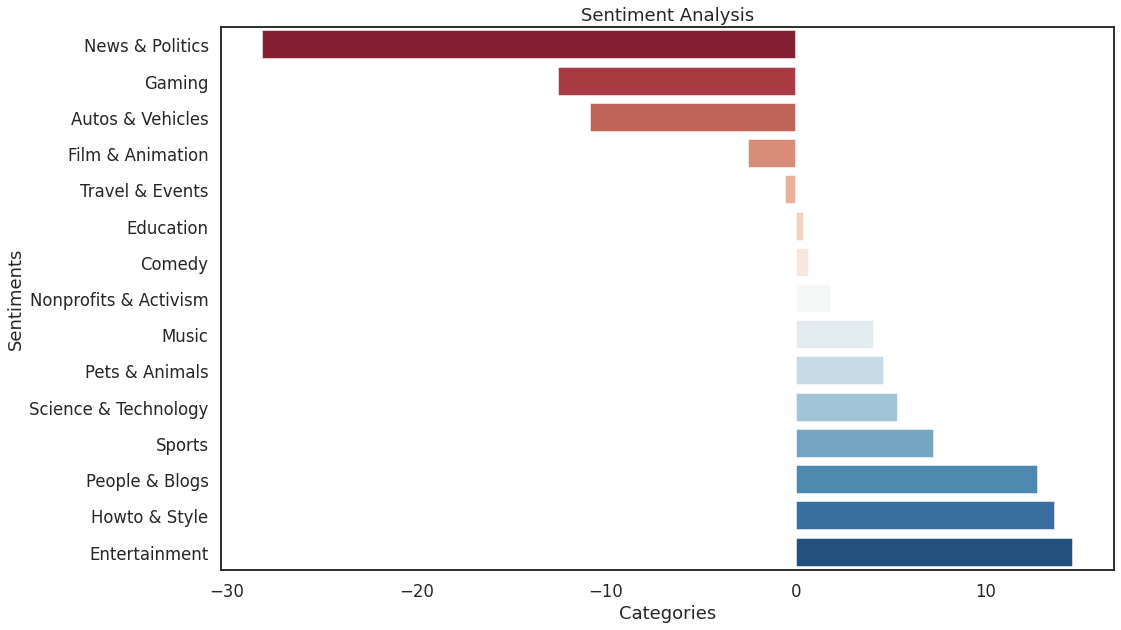

In [ ]:
categories = pd.DataFrame(categories)
polarities = pd.DataFrame(polarities)
sentiments = pd.concat([categories, polarities], axis=1)
sentiments.columns = ['category', 'polarity']
sentiments = sentiments.sort_values('polarity').reset_index()
fig = plt.figure(figsize=(16, 10))
sns.set(style="white", context="talk")
ax = sns.barplot(x=sentiments['polarity'], y=sentiments['category'], data=sentiments,orient='h',palette="RdBu")
plt.xlabel("Categories")
plt.ylabel("Sentiments")
plt.title("Sentiment Analysis")

(-0.5, 399.5, 199.5, -0.5)

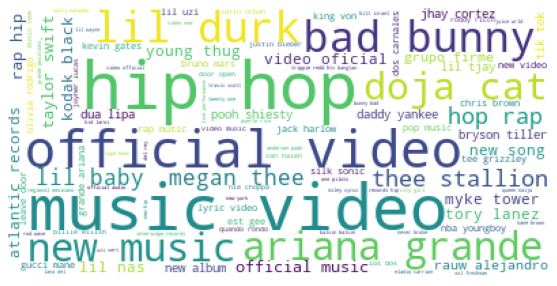

In [ ]:
neg = all[2] # music
plt.figure(figsize = (10,5))
cloud = WordCloud(background_color = 'white', max_words = 100,  max_font_size = 50)
cloud.generate(' '.join(neg))
plt.imshow(cloud)
plt.axis('off')

Give Sentiment score for every description, tags, title

using SentimentIntensityAnalyzer() on every important word and add their compound scores

In [ ]:
from collections import OrderedDict

def clean_sentence(sent):
  output=[]
  #sent = sent.lower()
  sent = re.sub('[^A-Za-z]+', ' ', sent) # to remove punctuation if any 
  sent = sent.strip()
  sent = word_tokenize(sent) # it just splits words into individual words
  sent = list(OrderedDict.fromkeys(sent))
  sent = [word for word in sent if ((len(word) > 2) and (word!="none") and (not word.isdigit()) and (not word in stopwords_list))]

  return sent


In [ ]:
def get_polarity(words):
    max = 300 #max 300 words per sentence/description
    frequency = nltk.FreqDist(words) # calculating frequency of each word
    temp = pd.DataFrame(frequency.most_common(max), columns=['Word', 'Frequency'])
    compound = .0 # polarity is initially 0.0
    polarities = []
    max_words=temp['Word'].head(max)
    for word in max_words:
        compound += SentimentIntensityAnalyzer().polarity_scores(word)['compound']
        
    return compound

In [ ]:
#Measure of positivity and negativity intensity in speech

def get_PolarityScore(sentence):
  cleaned= clean_sentence(sentence)
  return get_polarity(cleaned)



In [ ]:
print(get_PolarityScore('I hate you. You are awful'))
print(get_PolarityScore('I love you. You are amazing'))

-1.0307
1.2227999999999999


In [ ]:
Videos2=Videos

In [ ]:
Videos2['description_cleaned'] = Videos2.description.apply(lambda x: clean_sentence(x))

In [ ]:
Videos2['title_cleaned'] = Videos2.title.apply(lambda x: clean_sentence(x))

In [ ]:
Videos2['tags_cleaned'] = Videos2.tags.apply(lambda x: clean_sentence(x))

#tags are already the important words/sentences
#cleaning them result in redundant words

#one way:
#remove repeated words and calculate polarity

In [ ]:
Utitles=list(Videos2['title'].unique())
Udesc=list(Videos2['description'].unique())
Utags=list(Videos2['tags'].unique())

In [ ]:
print(len(Utitles))
print(len(Udesc))
print(len(Utags))

18328
18598
13496


Titles:

In [ ]:
titles_cleaned=[[title,clean_sentence(title)] for title in Utitles]

In [ ]:
titles_scores=[[title[0],title[1],get_polarity(title[1])] for title in titles_cleaned]

In [ ]:
import csv

with open("titles_polarities.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(titles_scores)

Tags:

In [ ]:
tags_cleaned=[[tags,clean_sentence(tags)] for tags in Utags]

In [ ]:
tags_scores=[[tags[0],tags[1],get_polarity(tags[1])] for tags in tags_cleaned]

In [ ]:
import csv

with open("tags_polarities.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(titles_scores)

descriptions:

In [ ]:
desc_cleaned=[[desc,clean_sentence(desc)] for desc in Udesc]

In [ ]:
desc_scores=[[desc[0],desc[1],get_polarity(desc[1])] for desc in desc_cleaned]

In [ ]:
import csv

with open("desc_polarities.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(desc_scores)

Using vader's SentimentIntensityAnalyzer() directly on a sentence 

Titles:

In [ ]:
Sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
titles_scores_vader=[[title, Sent_analyzer.polarity_scores(title)] for title in Utitles]

In [ ]:
titles_scores_vader[0]

['Supporting Actress in a Comedy: 73rd Emmys',
 {'compound': 0.6597, 'neg': 0.0, 'neu': 0.426, 'pos': 0.574}]

In [ ]:
titles_scores_vader_lists=[[title[0] , title[1]['compound'] , title[1]['neg'] ,  title[1]['neu'] ,  title[1]['pos'] ] for title in titles_scores_vader]

In [ ]:
with open("titles_polarities_vader.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(titles_scores_vader_lists)

Tags:



In [ ]:
Sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
tags_scores_vader=[[tags, Sent_analyzer.polarity_scores(tags)] for tags in Utags]

In [ ]:
tags_scores_vader[0]

['[None]', {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}]

In [ ]:
tags_scores_vader_lists=[[tags[0] , tags[1]['compound'] , tags[1]['neg'] ,  tags[1]['neu'] ,  tags[1]['pos'] ] for tags in tags_scores_vader]

In [ ]:
with open("tags_polarities_vader.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(tags_scores_vader_lists)

Description:

In [ ]:
Sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
desc_scores_vader=[[desc, Sent_analyzer.polarity_scores(desc)] for desc in Udesc]

In [ ]:
desc_scores_vader[0]

['Hannah Waddingham wins the Emmy for Supporting Actress in a Comedy Series at the 73rd Emmys.',
 {'compound': 0.8442, 'neg': 0.0, 'neu': 0.569, 'pos': 0.431}]

In [ ]:
desc_scores_vader_lists=[[desc[0] , desc[1]['compound'] , desc[1]['neg'] ,  desc[1]['neu'] ,  desc[1]['pos'] ] for desc in desc_scores_vader]

In [ ]:
with open("desc_polarities_vader.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(desc_scores_vader_lists)

pos + neu + neg = 1 

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

positive sentiment : (compound score >= 0.05) 

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)

# **Preparing the Data for Predictive Analytics**

In [ ]:
videosDF.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description,time_diff,isPublishedWeekend,isTrendingWeekend,published_year,published_month,published_day,trending_year,trending_month,trending_day,published_weekday,trending_weekday,published_month_name,title_length,tags_count,sponsered,likes/dislikes,comment_rate,dislike_rate,category_name
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,1 days,0,0,2020,8,11,2020,8,12,Tuesday,Wednesday,August,34,15,0,0.964,0.023,3.866e-03,People & Blogs
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,False,False,"While running her own modding shop, Ramya Pare...",1 days,0,0,2020,8,11,2020,8,12,Tuesday,Wednesday,August,60,25,0,0.981,0.007,1.173e-03,Gaming
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,False,False,I left youtube for a month and this is what ha...,1 days,0,0,2020,8,11,2020,8,12,Tuesday,Wednesday,August,53,30,0,0.993,0.020,1.289e-03,Entertainment
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,1 days,0,0,2020,8,11,2020,8,12,Tuesday,Wednesday,August,56,23,0,0.926,0.015,3.736e-03,Music
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,False,False,Transforming The LaBrant Family's empty white ...,1 days,0,0,2020,8,11,2020,8,12,Tuesday,Wednesday,August,55,33,1,0.979,0.002,8.577e-04,Howto & Style


In [ ]:
tags_sentiment = pd.read_csv("/content/drive/Shareddrives/DS Project/tags_polarities_vader.csv" )
description_sentiment = pd.read_csv("/content/drive/Shareddrives/DS Project/desc_polarities_vader.csv" )
titles_sentiment =pd.read_csv("/content/drive/Shareddrives/DS Project/titles_polarities_vader.csv" )
#tags_sentiment.columns=['tags' , 'tags_list' , 'scores']

In [ ]:
titles_sentiment['titles_compound'] = titles_sentiment['compound']
tags_sentiment['tags_compound'] = tags_sentiment['compound']
description_sentiment['desc_compound'] = description_sentiment['compound']

In [ ]:
#merge two dataframes on a column 
def merge_df(df1, df2, colName):
    return df1.merge(df2, on=colName)


In [ ]:

videosDF = merge_df(videosDF , description_sentiment[['description' , 'desc_compound']] , "description")
videosDF = merge_df(videosDF , titles_sentiment[['title', 'titles_compound']] , "title")
videosDF = merge_df(videosDF , tags_sentiment[['tags', 'tags_compound']] , "tags")

In [ ]:
'''
df = df.sort(columns=["IDName", "Time"])
df.drop_duplicates(subset=["IDName"], take_last=False)

'''

'\ndf = df.sort(columns=["IDName", "Time"])\ndf.drop_duplicates(subset=["IDName"], take_last=False)\n\n'

In [ ]:
tes = videosDF.groupby(['video_id']).agg('count').reset_index()

In [ ]:
tes['count_trending_days'] = tes["title"]

In [ ]:
# 
videos2df = videosDF.sort_values(["video_id", "trending_date"])
videos2df = videos2df.drop_duplicates(subset=["video_id"], keep='last').reset_index(drop=True)
videos2df = merge_df(videos2df , tes[['video_id', 'count_trending_days']] , "video_id")

In [ ]:
# 
videos2df['likes_slope'] = videos2df['likes']/videos2df["count_trending_days"]

In [ ]:
videos2df.shape

(17555, 39)

In [ ]:
# One-hot encoding on categories
categoryDF = pd.get_dummies(videos2df['category_name'], prefix='category')

In [ ]:
def concat_df(df1, df2):
    return pd.concat([df1, df2], axis=1)

In [ ]:
videos2df = concat_df(videos2df, categoryDF)

In [ ]:
videos2df.drop(videos2df.columns[-1], axis=1, inplace=True)

In [ ]:
videos2df.shape

(17555, 53)

In [ ]:
videos2df.columns

Index(['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle',
       'categoryId', 'trending_date', 'tags', 'view_count', 'likes',
       'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled',
       'description', 'time_diff', 'isPublishedWeekend', 'isTrendingWeekend',
       'published_year', 'published_month', 'published_day', 'trending_year',
       'trending_month', 'trending_day', 'published_weekday',
       'trending_weekday', 'published_month_name', 'title_length',
       'tags_count', 'sponsered', 'likes/dislikes', 'comment_rate',
       'dislike_rate', 'category_name', 'desc_compound', 'titles_compound',
       'tags_compound', 'count_trending_days', 'likes_slope',
       'category_Autos & Vehicles', 'category_Comedy', 'category_Education',
       'category_Entertainment', 'category_Film & Animation',
       'category_Gaming', 'category_Howto & Style', 'category_Music',
       'category_News & Politics', 'category_Nonprofits & Activism',
       'categ

# Predictive Analytics

In [ ]:
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import OneClassSVM
from sklearn.svm import LinearSVR , SVR
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot

In [ ]:
X = videos2df[[
        'likes', 'dislikes', 'comment_count',
              #  'likes_slope', 'likes/dislikes', 'comment_rate', 
       'isPublishedWeekend', 'isTrendingWeekend',
       'title_length', 'tags_count', 'sponsered', 
       'desc_compound', 'titles_compound', 'tags_compound', 
       'category_Autos & Vehicles', 'category_Comedy',
       'category_Education', 'category_Entertainment',
       'category_Film & Animation', 'category_Gaming',
       'category_Howto & Style', 'category_Music', 'category_News & Politics',
       'category_Nonprofits & Activism', 'category_People & Blogs',
       'category_Pets & Animals', 'category_Science & Technology',
       'category_Sports',
       'count_trending_days'
       ]]
Y = videos2df['view_count']

In [ ]:
# Normalizing
# X_scaler = preprocessing.MinMaxScaler()
# X_scaled = X_scaler.fit_transform(X)

# y_scaler = preprocessing.MinMaxScaler()
# y_scaled = y_scaler.fit_transform(Y)
# y_scaled = y_scaled.ravel()

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

X_scaled = normalize(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split (X, Y, test_size=0.33, random_state=42)

## Linear Regression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

reg.score(X_test, y_test)

# reg.coef_
# reg.intercept_

0.7227367277813698

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


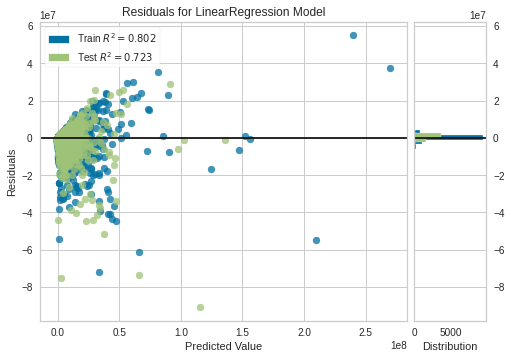

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [ ]:
visualizer = ResidualsPlot(reg)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

> we don't have a pattern n the residuals. hence, the linearity assumption is valid. 

In [ ]:
y_predict = reg.predict(X_test)

In [ ]:
# list(zip(y_test, y_predict))

In [ ]:
mean_squared_error(y_test, y_predict)


13038903874684.244

In [ ]:
np.square(np.subtract(y_test,y_predict)).mean()

13038903874684.295

## Decision Tree Regressor

In [ ]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

mse = mean_squared_error(y_test, regressor.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", regressor.score(X_test, y_test))

The mean squared error (MSE) on test set: 18061131215808.8242
The accuracy:  0.6185229223347939


## Random Forest Regressor

The mean squared error (MSE) on test set: 11359835524470.7500
The accuracy:  0.7600639291718678


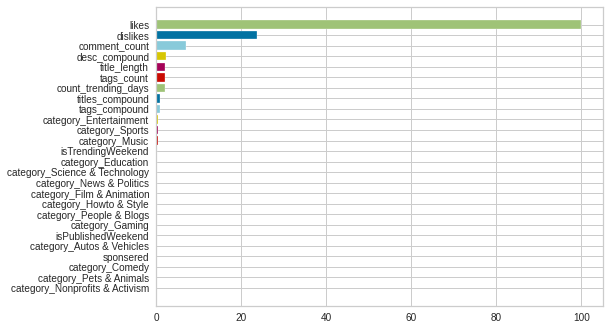

In [ ]:
regr = RandomForestRegressor(max_depth=16, random_state=0)

viz = FeatureImportances(regr)
viz.fit(X_train, y_train)
regr.fit(X_train, y_train)

mse = mean_squared_error(y_test, regr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", regr.score(X_test, y_test))

## Gradient Boost Regressor

**Gradient Boost** machine learning algorithm follows the “boosting” family of algorithms. The basis of boosting comes from the idea of strengthening weak hypotheses to create a strong hypothesis. Fundamentally, the strong hypothesis is a combination of weak hypotheses, where each weak hypothesis builds on the remaining observations that the previous weak hypothesis did not handle. Weak hypotheses are also referred to as weak learners. 

The first successful boosting algorithm was AdaBoost, or Adaptive Boosting. In AdaBoost, the weak learners are stumps, or single-split decision trees. The final prediction is a combination of all the stumps. Later, Gradient Boosting was developed as a more advanced generalization of AdaBoost. In Gradient Boost, the weak learners are full decision trees.

Gradient Boosting revolves around three elements:
1. Loss Function: a differentiable function, usually a squared error in regression
2. Weak learners: 
- full-sized decision trees with its split points based on purity scores
- Leafs are pseudo-residuals that are based on previous learners
- Each successive learner has lower loss
3. Additive Model: 
A weighted combination of the weak learners that follow the gradient (reduce the loss) with the weights being the learning rate

<img src="https://miro.medium.com/max/788/1*pEu2LNmxf9ttXHIALPcEBw.png" style="float: right;" width="540" height="394" />

For a full picture, the Gradient Boosting algorithm is:
0. The loss function is defined as input. In regression: <sup>1</sup>&frasl;<sub>2</sub>(Observed-Predicted)<sup>2</sup>
1. The model is initialized by a constant value: the average of the dependent variable
2. Loop for all trees specified m=1 to M:
  1. Compute the pseudo-residuals: -ve partial derivative with respect to predicted of the loss function then replace observed with y<sub>i</sub> and predicted as the previous tree predicted value
  2. Fit a regression tree to the residual values 
  3. Compute the output of each leaf: the average of all values in leaf
  4. Compute the predicted values up to that tree: the previous tree predicted value + the learning rate * the predicted value of that tree
3. The output is the predicted values up to the final tree 

We used the gradient boosting model as it can be tuned for a good fit and in general, they are known to produce better results than Random Forests regressor. Hence, we decided to experiment with it. 

References:

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/





> **Applying Gradient Boost Regressor on our dataset**

In [ ]:
params = {
    "n_estimators": 1000,
    "max_depth": 4,
    "min_samples_split": 8,
    "learning_rate": 0.01,
    "loss": "squared_error",
}
# params = {
#     "n_estimators": 500,
#     "max_depth": 4,
#     "min_samples_split": 5,
#     "learning_rate": 0.01,
#     "loss": "squared_error",
# }

In [ ]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", reg.score(X_test, y_test)* 100, "%")

The mean squared error (MSE) on test set: 10627422476098.4531
The accuracy:  77.55335465506714 %


## MLP

Multi-Layer Perceptron is basically a Feedforward Fully-Connected Neural Network.

A perceptron is a single neuron model that is the building block for the larger NN. Neurons are simple computational units that take weighted inputs and produce an output using an activation function, as shown in the figure below. 




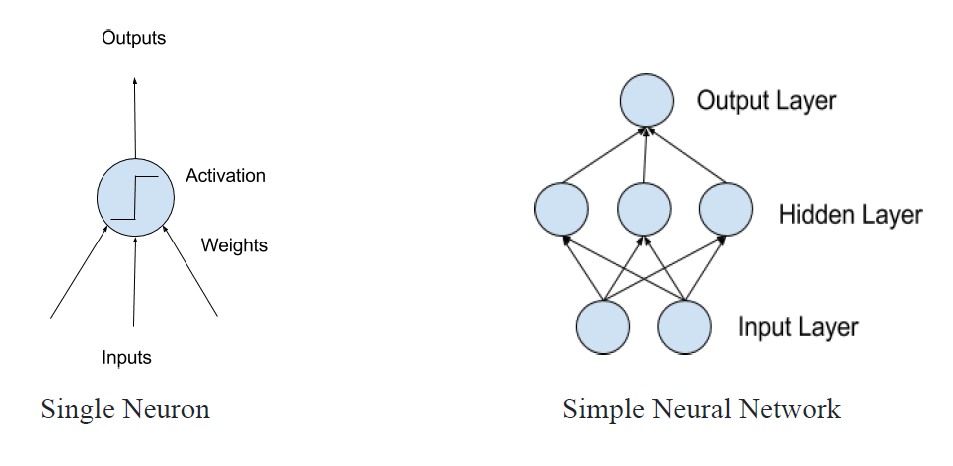

An activation function is a simple mapping of summed weighted input to the output of the neuron. It is called an activation function because it controls the threshold at which the neuron is activated and strength of the output signal. Here we use the ReLU (Rectified Linear Unit) activation function, as it is easier to train and achieves good performance.


A Feedforward Fully Connected Neural Network is composed of neurons arranged in three main types of layers: Input layer, hidden layers, and output layer. Each neuron in one layer has directed connections to the neurons of the subsequent layer. The input layer has number of neurons equal the number of input variables, which equals 26 in our problem. In the hidden layers, the more neurons and number of layers we have, the more complex and deep the network gets. These numbers are chosen based on the complexity of the problem and training set. In our case, 2 hidden layers, with 2048 neuron in the first layer, and 2 neurons in the second layer yielded the best results, with training time of around 8 minutes. The final/output layer is responsible for outputting the prediction (response variable), which in our case is the count of views and we have one neuron responsible for that.

The network is trained using specified number of iterations/epochs, in which the weights of the parameters keep getting adjusted every iteration. It learns through back-propagation technique, in which the network tries to minimize the mean squared error. Once the network is trained, we can use it to make predictions.

We considered this model for solving our problem because of the undoubtable power of neural networks to learn the representation in the training data and how it best relate to the output variable. MLP is a supervised learning method, which fits our problem. Also, the multilayer nature and nonlinearity of the architecture gives more predictive capability for the model to get the weight or contribution of every input variable we have to the view count. 

In [ ]:
regr = MLPRegressor(random_state=1, max_iter=1000, hidden_layer_sizes=(2048,2), learning_rate='adaptive', alpha=1e-5)
regr.fit(X_train, y_train)

mse = mean_squared_error(y_test, regr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", regr.score(X_test, y_test)* 100, "%")

The mean squared error (MSE) on test set: 10720063578415.7441
The accuracy:  77.35768331775495 %


## SVR

###Why Support Vector Regression (SVR)?
####Sickit Learn Map
the official sickit learn website has a guide of how to pick the right estimator or model for your project. If we walk through the tree-like guide the provide here, you will see that they suggest using SVRs with different kernels depending on different properties. It is also suitable for cases where we have fewer than 100K samples, which is the case in our project. Moreover, it is more suitable than other models like SGD if few features can do the prediction accurately. This was shown to be the case as around 4 features can give us a very accurate prediction of the number of views.


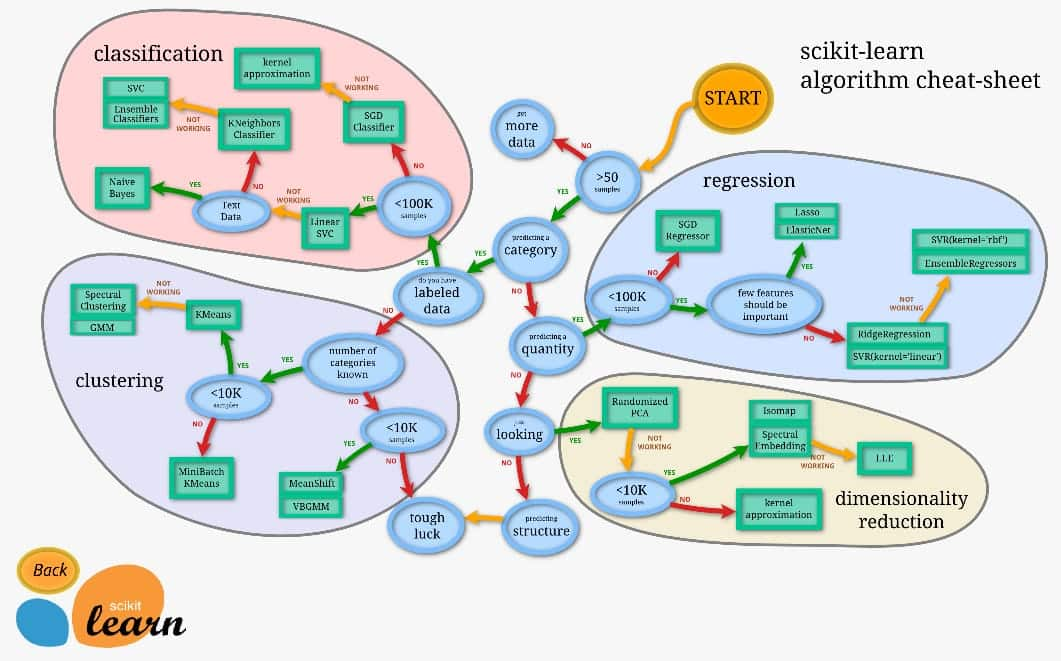
####What is Support Vector Regression?
Support vector regression is a slightly modified version of the support vector machine algorithms that is used for classification problems; however, by modiifying it, we can get it to do prediction for linear and non-linear data. The way SVM do this is by increasing the dimension of the data so that I can find a clear separation between the two classes. So, if the data was 1D, and it couldn't find a clear separation (say class A was on both ends, and class B was in the middle), it will increase the dimension to be 2D using a kernel for this, and then try to separate the data points, which is now easier to do. The separation will be a line (1D for 2D data). The same can be generalized so that data in 2D be elevated to 3D, and using a plane (2D separator) to do the classification.

To understand SVR, we need to understand SVM first, but for simplification, we will explain in an abstract manner.

####Kernels
a kernel is a function that is used to find the plane that separates the classes. It tries to find the hyperplane without increasing the computational complexity or cost. This is generally hard to achieve as the complexity increases with the dimension of the data.

####Hyperplanes
this is the plane that is used to do the separation, it doesn't have to be in 2D.

####decision boundaries
think of this as a demarction line where on one of its sides lies the positive samples and on the other side the negatives.

Now, we can explain briefly SVR. Mainly, there are two decision boundaries around our line, let's say at distance +a and -a from it. The two decision boundaries and the main line constitiute the hyperplane. The main idea is to minimze the margin and maximize the margins, knowing that we can tolerate some of the errors. The best fit line would be the one that has the maximum number of points with the minimum errors within the two boundaries near the line, and you use that line for prediction like linear regression.


> **Applying SVR to our dataset**

In [ ]:
regr = LinearSVR(random_state=0, tol=1e-5, max_iter=100000  )
regr.fit(X_train, y_train)

mse = mean_squared_error(y_test, regr.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", regr.score(X_test, y_test)* 100, "%")

The mean squared error (MSE) on test set: 13230574219122.2422
The accuracy:  72.05512363187079 %


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## SGD Regressor

Sklearn.linear_model.Sgdregressor. scikit. (n.d.). Retrieved December 26, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html 

**Stochastic Gradient Descent (SGD)** is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning. (Sklearn.linear_model.Sgdregressor, n.d.)

The advantages of Stochastic Gradient Descent are:


*   Efficiency.
*   Ease of implementation (lots of opportunities for code tuning).



The disadvantages of Stochastic Gradient Descent include:

* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

* SGD is sensitive to feature scaling.

The class SGDRegressor implements a plain stochastic gradient descent learning routine which supports different loss functions and penalties to fit linear regression models. SGDRegressor is well suited for regression problems with a large number of training samples (> 10.000) (Sklearn.linear_model.Sgdregressor, n.d.)

The concrete loss function can be set via the loss parameter. SGDRegressor supports the following loss functions:

* ```loss="squared_error"```: Ordinary least squares,

* ```loss="huber"```: Huber loss for robust regression,

* ```loss="epsilon_insensitive"```: linear Support Vector Regression.

**SGDRegressor** provide two criteria to stop the algorithm when a given level of convergence is reached:

* With ```early_stopping=True```, the input data is split into a training set and a validation set. The model is then fitted on the training set, and the stopping criterion is based on the prediction score (using the score method) computed on the validation set. The size of the validation set can be changed with the parameter validation_fraction.

* With ```early_stopping=False```, the model is fitted on the entire input data and the stopping criterion is based on the objective function computed on the training data.

**Mathmatical Formulation**

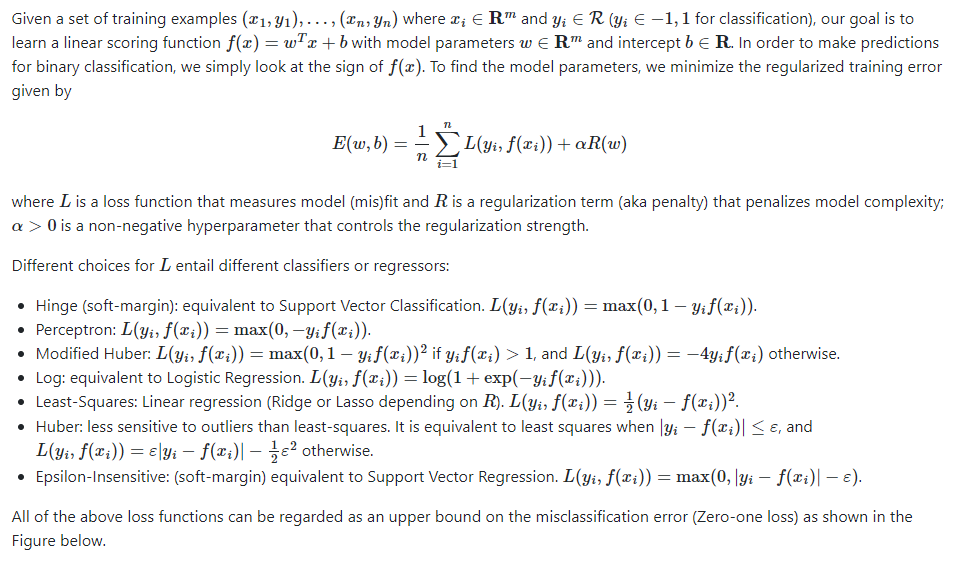

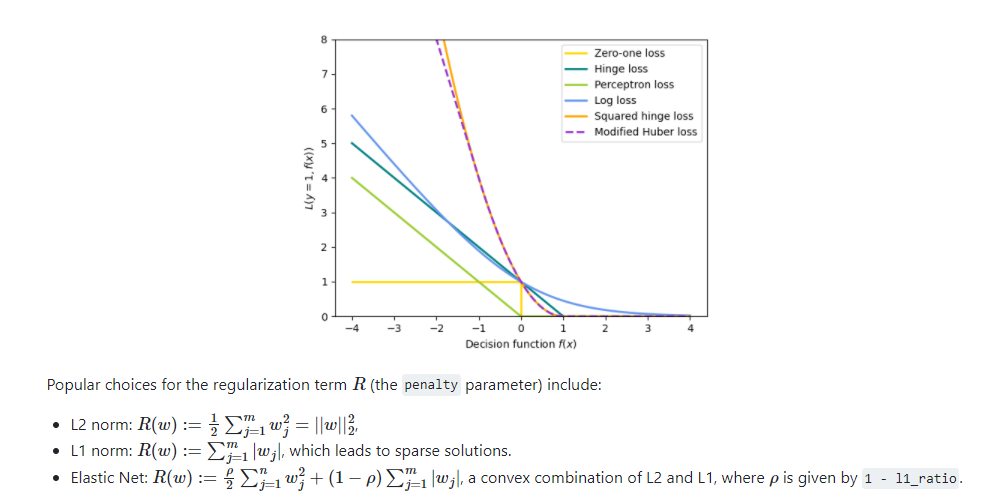

Stochastic gradient descent is an optimization method for unconstrained optimization problems. In contrast to (batch) gradient descent, SGD approximates the true gradient of **E(w,b)** by considering a single training example at a time.

**update rule**

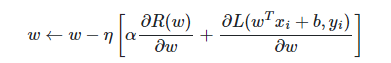

where **eta**  is the learning rate which controls the step-size in the parameter space. The intercept **b** is updated similarly but without regularization

**Reasons for selection**

1. It is an easy to train model as mentioned in the advantages 
2. Our problem satisfies the model requirementsin terms of having training samples > 10 k in addition to having the linearity assumption in our data. 

Hence, we decided to experiment with SGD Regressor for predicting the number of views in our problem. 

> **Applying SGD Regressor on our dataset**

In [ ]:
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=5000, tol=1e-7))
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The accuracy: ", reg.score(X_test, y_test)* 100, "%")

The mean squared error (MSE) on test set: 17298961550103.6387
The accuracy:  63.46210422855414 %


# Comparison between Models 

we compared the following models performance on the test dataset. 

*   **Linear Regression**
> Accuracy: 72.45% </br> 
> MSE: 13038903874684.393 
*   **Decision Tree Regressor** 
> Accuracy: 61.27% </br> 
> MSE: 18337900154986.3633
*   **Random Forest Regressor** 
> Accuracy: 76.07% </br> 
> MSE: 11330348855929.4746
*   **Gradient Boost Regressor** 
> Accuracy: 77.55% </br> 
> MSE: 10626671330729.8125
*   **MLP** 
> Accuracy: 77.36% </br> 
> MSE: 10720063578415.7441
*   **SVM** 
> Accuracy: 72.06% </br> 
> MSE: 13230574219122.2422
*   **SGD Regressor** 
> Accuracy: 73.253% </br> 
> MSE: 12663152466607.8789









# Intepretation of Results

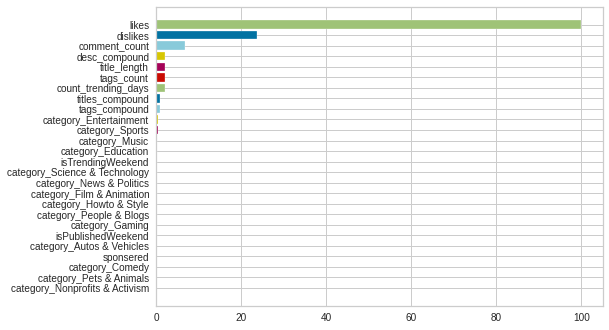

As we can see from the feature importance, the likes is most important feature. when tested alone, it generated 53% accuracy on the testing dataset. followed by dislikes count, comments count, description score, title length, counts of tags and the number of days that the video will make it to the youtube trending list, and the scores of the titles and the tags as well. Finally, The Entertainment and Score categories in 2020-2021 performed better than the Others. Hence, we recommend the youtubers to focus on the mentioned features as outlined in the next section. 

> One may assume that **likes** , **dislikes** , and **comments count** are leakage variables. However, in this problem we depend on them as features that affects the number of views. elaborating more, the number of views that a video will get in the future is affected by the KPIs that appears on the video in terms of likes count, dislikes count and comments count. hence, we are simulating a model in production that will run on specific time periods. 

# Optimization Problem 

we recommend Ads companies to do the following in order to maximize their profits:

It is implicitly assumed that trendy videos are the ones that are used to display the ads on in order to maximize the profit. However, we are differentiating trendy videos from each other in order to maximize the profit. 

1. Dynamically allocate their ads on videos that are predicted to have high number of views according to our model. elaborating more, it offers flexibility in ads allocation depending on making decisions in specific time spans.
2. Display their ads on the top 10 channels such as Mr. Beast, BlackPink, FFUNTV, SMTOWN, and Mr. Beast Gaming
3. Display their ads on videos with titles that has titles between 30-50 characters. 
4. Display their ads on videos with well-written descriptions 
5. Display their ads on videos between 4-5 pm because these times generate the highest views. 
6. Sponsored videos do not perform better than non-sponsored videos in terms of ads. hence, budget can be allocated in a better manner. 
7. Ads that are displayed on videos from Entertainment and Sports categories are predicted to score better in terms of views in 2020-2021.
8. display their ads on videos that have many tags since they are predicted to generate more views. 
9. All days have equal probabilities of having trendy videos. However, videos that are published on Fridays are more probable to be trendy. 


> **We are aware that the business model that youtube is using for ads displayed on videos during watching them is allocated by youtube and it is not the ad company or the youtuber's decision choice. However, what we are proposing is a direct contact between the youtuber and the ad company for a sponsorship video where part of the video's content is actually the ad.** 
